In [1]:
import json
import re
import random
import wandb
import optuna
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
from torch.utils.data import Dataset, DataLoader
import nltk
from nltk.corpus import stopwords
from imblearn.over_sampling import RandomOverSampler
import nlpaug.augmenter.word as naw
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt

#Model eğitimini izlemek için kullanılır.
wandb.init(project="chatbot")


wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find chatbot.ipynb.
wandb: Currently logged in as: hsyn-351942 (bertbot). Use `wandb login --relogin` to force relogin


In [2]:
# Load intents
def load_json_file(filename):
    with open(filename, encoding='utf-8') as f:
        file = json.load(f)
    return file

filename = 'C:/Users/Public/projectcode/database/intents.json'
intents = load_json_file(filename)

In [3]:
def create_df():
    df = pd.DataFrame({
        'Pattern': [],
        'Tag': []
    })
    return df

df = create_df()

In [4]:
def extract_json_info(json_file, df):
    for intent in json_file['intents']:
        for pattern in intent['patterns']:
            sentence_tag = [pattern, intent['tag']]
            df.loc[len(df.index)] = sentence_tag
    return df

df = extract_json_info(intents, df)

**NLTK stopwords indirilir ama Türkçe kelimleri alınır**

In [5]:
nltk.download('stopwords')
stop_words = set(stopwords.words('turkish'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hüseyin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Veri Ön İşleme işlemi**

In [6]:
def preprocess_text(text):
    # Türkçe karakterler ve küçük harf
    text = text.lower()
    # Noktalama ve gereksiz semboller
    text = re.sub(r'[^\w\s]', '', text)
    # Stop words kaldırma
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['Pattern'] = df['Pattern'].apply(preprocess_text)

**Veri Artırma**

In [7]:
# Veri artırma (Data Augmentation)
#Bu, bağlam içinde kelime değiştirme işlemi yapar.
aug = naw.ContextualWordEmbsAug(model_path='dbmdz/bert-base-turkish-uncased', action="substitute")

def augment_text(text):
    augmented_text = aug.augment(text)
    return augmented_text

df['Augmented_Pattern'] = df['Pattern'].apply(augment_text)
df_augmented = pd.concat([df, df[['Augmented_Pattern', 'Tag']].rename(columns={'Augmented_Pattern': 'Pattern'})])

**Bilinmeyen (unknown) etiketine sahip örnekler eklenir ve bu veriler DataFrame'e dahil edilir.**

In [8]:
# Bilinmeyen etiketi ve örnekleri ekleyin
unknown_label = 'bilinmeyen'
unknown_examples = [
    "Kararsızım",
    "Herhangi bir şey olur",
    "Farketmez söyle bir tane",
    "Bilmem",
    "Bilmiyorum sen film öner"
]

unknown_data = pd.DataFrame({'Pattern': [preprocess_text(example) for example in unknown_examples], 'Tag': [unknown_label] * len(unknown_examples)})

df_augmented = pd.concat([df_augmented, unknown_data], ignore_index=True)

**Etiketleri numaralandırıyoruz ve 'id2label' ve 'label2id' haritalarını oluşturduk sonrasında etiketleri sayısal değerlere dönüştürdük**

In [9]:
labels = df_augmented['Tag'].unique()
labels = [s.strip() for s in labels]
if unknown_label not in labels:
    labels.append(unknown_label)

num_labels = len(labels)
id2label = {id: label for id, label in enumerate(labels)}
label2id = {label: id for id, label in enumerate(labels)}

df_augmented['labels'] = df_augmented['Tag'].map(lambda x: label2id[x.strip()])
X = list(df_augmented['Pattern'])
y = list(df_augmented['labels'])

**Veri setini eğitim ve test olarak ayırıyoruz. Ardından BERT tokenizer ile metinler tokenize(metni anlamlandırmak için metni küçük parçalara ayırmak) edilir.**

In [10]:
# Eğitim ve test verisini ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [11]:
model_name = "dbmdz/bert-base-turkish-uncased"
max_len = 256
tokenizer = BertTokenizer.from_pretrained(model_name, max_length=max_len)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, id2label=id2label, label2id=label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
X_train = [str(x) for x in X_train]
X_test = [str(x) for x in X_test]

#Eğitim ve test verilerini tokinize ettik
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=max_len)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=max_len)

**Özel bir PyTorch Dataset sınıfı tanımlanır. Bu sınıf verileri getitem ve len yöntemleriyle alır ve boyutunu döner.**

**Veri hazırlama sürecini kolaylaştırabilir ve modelinize uygun formatlarda veri sağlar.**

In [13]:
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [14]:
train_dataset = CustomDataset(train_encodings, y_train)
test_dataset = CustomDataset(test_encodings, y_test)

In [15]:
#Model eğitiminde sınıf dengesizliklerini gidermek için sınıf ağırlıkları hesaplanır.
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [16]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

**Optuna ile Hiperparametre Optimizasyonu**

**Makine öğrenimi modelinizin hiperparametrelerini otomatik olarak ayarlanır.**

**Performansı iyileştirir.**

In [17]:
def objective(trial):
    # Define hyperparameters to search
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    
    # Update training arguments
    training_args = TrainingArguments(
        output_dir='C:/Users/Public/projectcode/output',
        do_train=True,
        do_eval=True,
        num_train_epochs=10,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_steps=200,
        weight_decay=0.01,
        logging_dir='C:/Users/Public/multi-class-logs',
        logging_steps=50,
        evaluation_strategy="steps",
        eval_steps=50,
        save_strategy="steps",
        load_best_model_at_end=True,
        learning_rate=learning_rate
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )
    
    trainer.train()
    eval_results = trainer.evaluate(eval_dataset=test_dataset)
    return eval_results['eval_Accuracy']

In [18]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print('Best trial:', study.best_trial.params)

[I 2024-06-12 16:53:05,294] A new study created in memory with name: no-name-c7545e9f-e683-4f40-9903-e60af4f92a94


  0%|          | 0/360 [00:00<?, ?it/s]

{'loss': 3.9115, 'grad_norm': 8.556312561035156, 'learning_rate': 3.5328670205606116e-06, 'epoch': 1.39}


  0%|          | 0/9 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 3.8758161067962646, 'eval_Accuracy': 0.045936395759717315, 'eval_F1': 0.013024928195789754, 'eval_Precision': 0.010113065886060014, 'eval_Recall': 0.027141112855398573, 'eval_runtime': 0.2054, 'eval_samples_per_second': 1377.857, 'eval_steps_per_second': 43.819, 'epoch': 1.39}
{'loss': 3.8628, 'grad_norm': 9.20788860321045, 'learning_rate': 7.065734041121223e-06, 'epoch': 2.78}


  0%|          | 0/9 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 3.8150389194488525, 'eval_Accuracy': 0.0706713780918728, 'eval_F1': 0.02310625654403743, 'eval_Precision': 0.01948812285072823, 'eval_Recall': 0.041297186609686606, 'eval_runtime': 0.197, 'eval_samples_per_second': 1436.546, 'eval_steps_per_second': 45.685, 'epoch': 2.78}
{'loss': 3.734, 'grad_norm': 4.517448425292969, 'learning_rate': 1.0598601061681835e-05, 'epoch': 4.17}


  0%|          | 0/9 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 3.6170575618743896, 'eval_Accuracy': 0.1978798586572438, 'eval_F1': 0.11580403907599351, 'eval_Precision': 0.1699713656914744, 'eval_Recall': 0.18587327024827024, 'eval_runtime': 0.1994, 'eval_samples_per_second': 1419.194, 'eval_steps_per_second': 45.133, 'epoch': 4.17}
{'loss': 3.3658, 'grad_norm': 5.460495471954346, 'learning_rate': 1.4131468082242446e-05, 'epoch': 5.56}


  0%|          | 0/9 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 3.179471731185913, 'eval_Accuracy': 0.36042402826855124, 'eval_F1': 0.29283976524505617, 'eval_Precision': 0.3730068025298288, 'eval_Recall': 0.3585584554334555, 'eval_runtime': 0.197, 'eval_samples_per_second': 1436.541, 'eval_steps_per_second': 45.685, 'epoch': 5.56}
{'loss': 2.8716, 'grad_norm': 5.817872524261475, 'learning_rate': 9.715384306541682e-06, 'epoch': 6.94}


  0%|          | 0/9 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 2.7594475746154785, 'eval_Accuracy': 0.4452296819787986, 'eval_F1': 0.36183554623806974, 'eval_Precision': 0.39342274924221515, 'eval_Recall': 0.42998448310948306, 'eval_runtime': 0.2007, 'eval_samples_per_second': 1410.071, 'eval_steps_per_second': 44.843, 'epoch': 6.94}
{'loss': 2.4625, 'grad_norm': 5.484087944030762, 'learning_rate': 5.299300530840918e-06, 'epoch': 8.33}


  0%|          | 0/9 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 2.5316364765167236, 'eval_Accuracy': 0.5017667844522968, 'eval_F1': 0.4404637412211671, 'eval_Precision': 0.49251417949334614, 'eval_Recall': 0.4993297212047212, 'eval_runtime': 0.217, 'eval_samples_per_second': 1304.155, 'eval_steps_per_second': 41.475, 'epoch': 8.33}
{'loss': 2.2875, 'grad_norm': 4.940638065338135, 'learning_rate': 8.832167551401529e-07, 'epoch': 9.72}


  0%|          | 0/9 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 2.4393482208251953, 'eval_Accuracy': 0.5123674911660777, 'eval_F1': 0.4544811244170826, 'eval_Precision': 0.4970395345395346, 'eval_Recall': 0.5137146418396418, 'eval_runtime': 0.206, 'eval_samples_per_second': 1373.781, 'eval_steps_per_second': 43.689, 'epoch': 9.72}
{'train_runtime': 38.1118, 'train_samples_per_second': 297.021, 'train_steps_per_second': 9.446, 'train_loss': 3.1873502678341334, 'epoch': 10.0}


  0%|          | 0/9 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-06-12 16:53:44,309] Trial 0 finished with value: 0.5123674911660777 and parameters: {'learning_rate': 1.4131468082242446e-05, 'batch_size': 32}. Best is trial 0 with value: 0.5123674911660777.


  0%|          | 0/710 [00:00<?, ?it/s]

{'loss': 2.1813, 'grad_norm': 8.084196090698242, 'learning_rate': 6.489822815678224e-06, 'epoch': 0.7}


  0%|          | 0/18 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 2.380458116531372, 'eval_Accuracy': 0.5300353356890459, 'eval_F1': 0.4662346450908819, 'eval_Precision': 0.5205293038932745, 'eval_Recall': 0.526932615995116, 'eval_runtime': 0.216, 'eval_samples_per_second': 1310.397, 'eval_steps_per_second': 83.347, 'epoch': 0.7}
{'loss': 2.128, 'grad_norm': 7.2298126220703125, 'learning_rate': 1.2979645631356448e-05, 'epoch': 1.41}


  0%|          | 0/18 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 2.257030963897705, 'eval_Accuracy': 0.5477031802120141, 'eval_F1': 0.48980406054548203, 'eval_Precision': 0.5204924772939479, 'eval_Recall': 0.5489564255189255, 'eval_runtime': 0.217, 'eval_samples_per_second': 1304.146, 'eval_steps_per_second': 82.949, 'epoch': 1.41}
{'loss': 1.9281, 'grad_norm': 8.147920608520508, 'learning_rate': 1.9469468447034672e-05, 'epoch': 2.11}


  0%|          | 0/18 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 2.0304689407348633, 'eval_Accuracy': 0.6148409893992933, 'eval_F1': 0.5539516583634231, 'eval_Precision': 0.5694042358104858, 'eval_Recall': 0.6008496133496134, 'eval_runtime': 0.22, 'eval_samples_per_second': 1286.363, 'eval_steps_per_second': 81.818, 'epoch': 2.11}
{'loss': 1.6222, 'grad_norm': 5.831097602844238, 'learning_rate': 2.5959291262712896e-05, 'epoch': 2.82}


  0%|          | 0/18 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.7688329219818115, 'eval_Accuracy': 0.657243816254417, 'eval_F1': 0.6180958078919895, 'eval_Precision': 0.6664597098807624, 'eval_Recall': 0.6730648402523403, 'eval_runtime': 0.222, 'eval_samples_per_second': 1274.778, 'eval_steps_per_second': 81.081, 'epoch': 2.82}
{'loss': 1.2976, 'grad_norm': 7.655599117279053, 'learning_rate': 2.3414262707544964e-05, 'epoch': 3.52}


  0%|          | 0/18 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.5416274070739746, 'eval_Accuracy': 0.6607773851590106, 'eval_F1': 0.6262811782562637, 'eval_Precision': 0.6564965127465128, 'eval_Recall': 0.6746178011803012, 'eval_runtime': 0.2309, 'eval_samples_per_second': 1225.525, 'eval_steps_per_second': 77.949, 'epoch': 3.52}
{'loss': 1.0525, 'grad_norm': 8.630342483520508, 'learning_rate': 2.0869234152377036e-05, 'epoch': 4.23}


  0%|          | 0/18 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.432309865951538, 'eval_Accuracy': 0.6501766784452296, 'eval_F1': 0.6295265116916332, 'eval_Precision': 0.6745668683168683, 'eval_Recall': 0.6662361365486366, 'eval_runtime': 0.2311, 'eval_samples_per_second': 1224.714, 'eval_steps_per_second': 77.897, 'epoch': 4.23}
{'loss': 0.8761, 'grad_norm': 10.634736061096191, 'learning_rate': 1.8324205597209104e-05, 'epoch': 4.93}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.2919690608978271, 'eval_Accuracy': 0.6784452296819788, 'eval_F1': 0.6430988615971033, 'eval_Precision': 0.6854083994708994, 'eval_Recall': 0.6948558964183963, 'eval_runtime': 0.2429, 'eval_samples_per_second': 1165.065, 'eval_steps_per_second': 74.103, 'epoch': 4.93}
{'loss': 0.669, 'grad_norm': 9.168787956237793, 'learning_rate': 1.577917704204117e-05, 'epoch': 5.63}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.2091338634490967, 'eval_Accuracy': 0.7173144876325088, 'eval_F1': 0.7028939958390422, 'eval_Precision': 0.7631989538239538, 'eval_Recall': 0.7400195868945868, 'eval_runtime': 0.232, 'eval_samples_per_second': 1219.759, 'eval_steps_per_second': 77.582, 'epoch': 5.63}
{'loss': 0.5557, 'grad_norm': 7.117446422576904, 'learning_rate': 1.323414848687324e-05, 'epoch': 6.34}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.17600417137146, 'eval_Accuracy': 0.6925795053003534, 'eval_F1': 0.6776917618200513, 'eval_Precision': 0.712205155955156, 'eval_Recall': 0.7178978428978429, 'eval_runtime': 0.233, 'eval_samples_per_second': 1214.668, 'eval_steps_per_second': 77.258, 'epoch': 6.34}
{'loss': 0.489, 'grad_norm': 3.9788403511047363, 'learning_rate': 1.068911993170531e-05, 'epoch': 7.04}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.168513298034668, 'eval_Accuracy': 0.7067137809187279, 'eval_F1': 0.6880107750818535, 'eval_Precision': 0.7363760964912279, 'eval_Recall': 0.7299692205942206, 'eval_runtime': 0.2229, 'eval_samples_per_second': 1269.525, 'eval_steps_per_second': 80.747, 'epoch': 7.04}
{'loss': 0.415, 'grad_norm': 4.414173126220703, 'learning_rate': 8.14409137653738e-06, 'epoch': 7.75}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.107627034187317, 'eval_Accuracy': 0.7173144876325088, 'eval_F1': 0.6980251390825241, 'eval_Precision': 0.7424459221334221, 'eval_Recall': 0.7344157000407, 'eval_runtime': 0.2261, 'eval_samples_per_second': 1251.774, 'eval_steps_per_second': 79.618, 'epoch': 7.75}
{'loss': 0.3515, 'grad_norm': 3.7128255367279053, 'learning_rate': 5.599062821369449e-06, 'epoch': 8.45}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.1011933088302612, 'eval_Accuracy': 0.7173144876325088, 'eval_F1': 0.6963046559921561, 'eval_Precision': 0.7274350649350648, 'eval_Recall': 0.7418987840862842, 'eval_runtime': 0.24, 'eval_samples_per_second': 1179.167, 'eval_steps_per_second': 75.0, 'epoch': 8.45}
{'loss': 0.3292, 'grad_norm': 2.5975489616394043, 'learning_rate': 3.054034266201517e-06, 'epoch': 9.15}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.0851999521255493, 'eval_Accuracy': 0.7243816254416962, 'eval_F1': 0.7030936549976797, 'eval_Precision': 0.740827922077922, 'eval_Recall': 0.7396074989824989, 'eval_runtime': 0.233, 'eval_samples_per_second': 1214.621, 'eval_steps_per_second': 77.255, 'epoch': 9.15}
{'loss': 0.3062, 'grad_norm': 2.9123849868774414, 'learning_rate': 5.090057110335862e-07, 'epoch': 9.86}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.0770323276519775, 'eval_Accuracy': 0.7279151943462897, 'eval_F1': 0.7056905247530247, 'eval_Precision': 0.7411662411662411, 'eval_Recall': 0.7424844831094831, 'eval_runtime': 0.232, 'eval_samples_per_second': 1219.823, 'eval_steps_per_second': 77.586, 'epoch': 9.86}
{'train_runtime': 58.0877, 'train_samples_per_second': 194.878, 'train_steps_per_second': 12.223, 'train_loss': 1.004309084046055, 'epoch': 10.0}


  0%|          | 0/18 [00:00<?, ?it/s]

[I 2024-06-12 16:54:42,898] Trial 1 finished with value: 0.7067137809187279 and parameters: {'learning_rate': 2.5959291262712896e-05, 'batch_size': 16}. Best is trial 1 with value: 0.7067137809187279.


  0%|          | 0/1420 [00:00<?, ?it/s]

{'loss': 0.3451, 'grad_norm': 13.984935760498047, 'learning_rate': 6.2063886389460435e-06, 'epoch': 0.35}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.1345168352127075, 'eval_Accuracy': 0.6996466431095406, 'eval_F1': 0.6730547056572598, 'eval_Precision': 0.7194842772967774, 'eval_Recall': 0.7187245624745624, 'eval_runtime': 0.307, 'eval_samples_per_second': 921.814, 'eval_steps_per_second': 117.263, 'epoch': 0.35}
{'loss': 0.4101, 'grad_norm': 23.50868797302246, 'learning_rate': 1.2412777277892087e-05, 'epoch': 0.7}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.1340256929397583, 'eval_Accuracy': 0.7208480565371025, 'eval_F1': 0.6971060752662276, 'eval_Precision': 0.7362716687552213, 'eval_Recall': 0.735341625966626, 'eval_runtime': 0.324, 'eval_samples_per_second': 873.477, 'eval_steps_per_second': 111.114, 'epoch': 0.7}
{'loss': 0.4446, 'grad_norm': 2.6062121391296387, 'learning_rate': 1.861916591683813e-05, 'epoch': 1.06}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.088517189025879, 'eval_Accuracy': 0.7243816254416962, 'eval_F1': 0.7104418242420497, 'eval_Precision': 0.7483803811928812, 'eval_Recall': 0.7427668396418395, 'eval_runtime': 0.3091, 'eval_samples_per_second': 915.626, 'eval_steps_per_second': 116.475, 'epoch': 1.06}
{'loss': 0.3676, 'grad_norm': 2.4978864192962646, 'learning_rate': 2.4825554555784174e-05, 'epoch': 1.41}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.1133973598480225, 'eval_Accuracy': 0.7279151943462897, 'eval_F1': 0.7091486305089246, 'eval_Precision': 0.7546439093314093, 'eval_Recall': 0.7536038614163614, 'eval_runtime': 0.3081, 'eval_samples_per_second': 918.609, 'eval_steps_per_second': 116.855, 'epoch': 1.41}
{'loss': 0.3434, 'grad_norm': 11.82500171661377, 'learning_rate': 2.3808113795301215e-05, 'epoch': 1.76}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.0948034524917603, 'eval_Accuracy': 0.7279151943462897, 'eval_F1': 0.7088657469990337, 'eval_Precision': 0.7519548160173161, 'eval_Recall': 0.7506372100122101, 'eval_runtime': 0.311, 'eval_samples_per_second': 909.969, 'eval_steps_per_second': 115.756, 'epoch': 1.76}
{'loss': 0.278, 'grad_norm': 2.058232307434082, 'learning_rate': 2.279067303481826e-05, 'epoch': 2.11}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.1044560670852661, 'eval_Accuracy': 0.7137809187279152, 'eval_F1': 0.6887047277400539, 'eval_Precision': 0.7252847268472268, 'eval_Recall': 0.7352354242979242, 'eval_runtime': 0.3131, 'eval_samples_per_second': 903.921, 'eval_steps_per_second': 114.986, 'epoch': 2.11}
{'loss': 0.2013, 'grad_norm': 15.502352714538574, 'learning_rate': 2.17732322743353e-05, 'epoch': 2.46}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.1384509801864624, 'eval_Accuracy': 0.7102473498233216, 'eval_F1': 0.6887397652084185, 'eval_Precision': 0.7165306337181336, 'eval_Recall': 0.7261815730565729, 'eval_runtime': 0.327, 'eval_samples_per_second': 865.442, 'eval_steps_per_second': 110.092, 'epoch': 2.46}
{'loss': 0.267, 'grad_norm': 3.9442405700683594, 'learning_rate': 2.0755791513852342e-05, 'epoch': 2.82}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.1090978384017944, 'eval_Accuracy': 0.7208480565371025, 'eval_F1': 0.7036831571206571, 'eval_Precision': 0.7380914802789803, 'eval_Recall': 0.7374084249084248, 'eval_runtime': 0.308, 'eval_samples_per_second': 918.812, 'eval_steps_per_second': 116.881, 'epoch': 2.82}
{'loss': 0.2445, 'grad_norm': 4.742835521697998, 'learning_rate': 1.9738350753369383e-05, 'epoch': 3.17}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.0249882936477661, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.7492531624865215, 'eval_Precision': 0.7792042448292449, 'eval_Recall': 0.7681681166056166, 'eval_runtime': 0.327, 'eval_samples_per_second': 865.423, 'eval_steps_per_second': 110.089, 'epoch': 3.17}
{'loss': 0.1522, 'grad_norm': 0.8976359963417053, 'learning_rate': 1.8720909992886424e-05, 'epoch': 3.52}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.1292743682861328, 'eval_Accuracy': 0.7173144876325088, 'eval_F1': 0.7085912083914002, 'eval_Precision': 0.7329887126762126, 'eval_Recall': 0.734004884004884, 'eval_runtime': 0.3181, 'eval_samples_per_second': 889.697, 'eval_steps_per_second': 113.177, 'epoch': 3.52}
{'loss': 0.231, 'grad_norm': 17.20153045654297, 'learning_rate': 1.7703469232403468e-05, 'epoch': 3.87}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.0504372119903564, 'eval_Accuracy': 0.7455830388692579, 'eval_F1': 0.7272213485187556, 'eval_Precision': 0.7622195512820512, 'eval_Recall': 0.7608707264957264, 'eval_runtime': 0.306, 'eval_samples_per_second': 924.839, 'eval_steps_per_second': 117.647, 'epoch': 3.87}
{'loss': 0.1175, 'grad_norm': 1.2147891521453857, 'learning_rate': 1.668602847192051e-05, 'epoch': 4.23}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.0245283842086792, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.7387169572711033, 'eval_Precision': 0.7695826164576163, 'eval_Recall': 0.7713452635327634, 'eval_runtime': 0.313, 'eval_samples_per_second': 904.133, 'eval_steps_per_second': 115.013, 'epoch': 4.23}
{'loss': 0.152, 'grad_norm': 13.789227485656738, 'learning_rate': 1.5668587711437554e-05, 'epoch': 4.58}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.0855191946029663, 'eval_Accuracy': 0.7314487632508834, 'eval_F1': 0.7211599470790647, 'eval_Precision': 0.7438971907721909, 'eval_Recall': 0.7549278846153845, 'eval_runtime': 0.3201, 'eval_samples_per_second': 884.164, 'eval_steps_per_second': 112.473, 'epoch': 4.58}
{'loss': 0.1008, 'grad_norm': 19.854440689086914, 'learning_rate': 1.4651146950954595e-05, 'epoch': 4.93}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.1047165393829346, 'eval_Accuracy': 0.734982332155477, 'eval_F1': 0.7199780702828305, 'eval_Precision': 0.7402936762311761, 'eval_Recall': 0.7554983211233212, 'eval_runtime': 0.343, 'eval_samples_per_second': 825.058, 'eval_steps_per_second': 104.954, 'epoch': 4.93}
{'loss': 0.1083, 'grad_norm': 1.0730907917022705, 'learning_rate': 1.3633706190471637e-05, 'epoch': 5.28}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.07317054271698, 'eval_Accuracy': 0.7420494699646644, 'eval_F1': 0.7184825223795812, 'eval_Precision': 0.73600965007215, 'eval_Recall': 0.7547930657305657, 'eval_runtime': 0.3167, 'eval_samples_per_second': 893.721, 'eval_steps_per_second': 113.689, 'epoch': 5.28}
{'loss': 0.1122, 'grad_norm': 9.470405578613281, 'learning_rate': 1.2616265429988679e-05, 'epoch': 5.63}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.120727777481079, 'eval_Accuracy': 0.7314487632508834, 'eval_F1': 0.7174316383803276, 'eval_Precision': 0.7507853835978836, 'eval_Recall': 0.7536769943019942, 'eval_runtime': 0.317, 'eval_samples_per_second': 892.745, 'eval_steps_per_second': 113.565, 'epoch': 5.63}
{'loss': 0.0719, 'grad_norm': 0.32506945729255676, 'learning_rate': 1.1598824669505721e-05, 'epoch': 5.99}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.120985984802246, 'eval_Accuracy': 0.7385159010600707, 'eval_F1': 0.7114673860851279, 'eval_Precision': 0.7312858909797684, 'eval_Recall': 0.7466802471904513, 'eval_runtime': 0.317, 'eval_samples_per_second': 892.745, 'eval_steps_per_second': 113.565, 'epoch': 5.99}
{'loss': 0.0816, 'grad_norm': 23.58729362487793, 'learning_rate': 1.0581383909022762e-05, 'epoch': 6.34}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.117323398590088, 'eval_Accuracy': 0.7279151943462897, 'eval_F1': 0.7061077612600327, 'eval_Precision': 0.7302297475766863, 'eval_Recall': 0.7356407764571028, 'eval_runtime': 0.327, 'eval_samples_per_second': 865.481, 'eval_steps_per_second': 110.097, 'epoch': 6.34}
{'loss': 0.1182, 'grad_norm': 16.403663635253906, 'learning_rate': 9.563943148539805e-06, 'epoch': 6.69}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.0945062637329102, 'eval_Accuracy': 0.7455830388692579, 'eval_F1': 0.7295644933125583, 'eval_Precision': 0.7522298881673882, 'eval_Recall': 0.7607715201465202, 'eval_runtime': 0.317, 'eval_samples_per_second': 892.744, 'eval_steps_per_second': 113.565, 'epoch': 6.69}
{'loss': 0.0733, 'grad_norm': 0.22622230648994446, 'learning_rate': 8.546502388056846e-06, 'epoch': 7.04}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.1470683813095093, 'eval_Accuracy': 0.734982332155477, 'eval_F1': 0.7250456996635402, 'eval_Precision': 0.749822631072631, 'eval_Recall': 0.7587638634513634, 'eval_runtime': 0.322, 'eval_samples_per_second': 878.883, 'eval_steps_per_second': 111.801, 'epoch': 7.04}
{'loss': 0.0691, 'grad_norm': 0.34495529532432556, 'learning_rate': 7.529061627573889e-06, 'epoch': 7.39}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.1946645975112915, 'eval_Accuracy': 0.7137809187279152, 'eval_F1': 0.6909566534432271, 'eval_Precision': 0.7245950761256884, 'eval_Recall': 0.7222147467045427, 'eval_runtime': 0.384, 'eval_samples_per_second': 736.978, 'eval_steps_per_second': 93.75, 'epoch': 7.39}
{'loss': 0.0839, 'grad_norm': 0.1680477112531662, 'learning_rate': 6.5116208670909316e-06, 'epoch': 7.75}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.132873296737671, 'eval_Accuracy': 0.7420494699646644, 'eval_F1': 0.7185939582556125, 'eval_Precision': 0.7421135553788616, 'eval_Recall': 0.7470446786773318, 'eval_runtime': 0.342, 'eval_samples_per_second': 827.485, 'eval_steps_per_second': 105.263, 'epoch': 7.75}
{'train_runtime': 86.5951, 'train_samples_per_second': 130.723, 'train_steps_per_second': 16.398, 'train_loss': 0.19879715182564475, 'epoch': 7.75}


  0%|          | 0/36 [00:00<?, ?it/s]

[I 2024-06-12 16:56:10,182] Trial 2 finished with value: 0.7173144876325088 and parameters: {'learning_rate': 2.4825554555784174e-05, 'batch_size': 8}. Best is trial 2 with value: 0.7173144876325088.


  0%|          | 0/710 [00:00<?, ?it/s]

{'loss': 0.1112, 'grad_norm': 3.2686243057250977, 'learning_rate': 7.942297049875997e-06, 'epoch': 0.7}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.035225749015808, 'eval_Accuracy': 0.7385159010600707, 'eval_F1': 0.7215412113757701, 'eval_Precision': 0.7545379389129389, 'eval_Recall': 0.7527606074481074, 'eval_runtime': 0.2445, 'eval_samples_per_second': 1157.556, 'eval_steps_per_second': 73.625, 'epoch': 0.7}
{'loss': 0.1283, 'grad_norm': 6.271010398864746, 'learning_rate': 1.5884594099751994e-05, 'epoch': 1.41}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.0426803827285767, 'eval_Accuracy': 0.7455830388692579, 'eval_F1': 0.7248067863804758, 'eval_Precision': 0.7406941438191438, 'eval_Recall': 0.7658558455433456, 'eval_runtime': 0.231, 'eval_samples_per_second': 1225.334, 'eval_steps_per_second': 77.936, 'epoch': 1.41}
{'loss': 0.1108, 'grad_norm': 0.6471868753433228, 'learning_rate': 2.3826891149627993e-05, 'epoch': 2.11}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.071732521057129, 'eval_Accuracy': 0.7420494699646644, 'eval_F1': 0.7265917687976512, 'eval_Precision': 0.7596478174603174, 'eval_Recall': 0.7571104242979244, 'eval_runtime': 0.2378, 'eval_samples_per_second': 1190.093, 'eval_steps_per_second': 75.695, 'epoch': 2.11}
{'loss': 0.1057, 'grad_norm': 0.5835080146789551, 'learning_rate': 3.176918819950399e-05, 'epoch': 2.82}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.1064929962158203, 'eval_Accuracy': 0.7455830388692579, 'eval_F1': 0.731624617833857, 'eval_Precision': 0.7608600889850891, 'eval_Recall': 0.7652440730565729, 'eval_runtime': 0.266, 'eval_samples_per_second': 1063.912, 'eval_steps_per_second': 67.669, 'epoch': 2.82}
{'loss': 0.0849, 'grad_norm': 0.8998951315879822, 'learning_rate': 2.865456190543497e-05, 'epoch': 3.52}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.184242844581604, 'eval_Accuracy': 0.7314487632508834, 'eval_F1': 0.7227345424715951, 'eval_Precision': 0.7487681878306879, 'eval_Recall': 0.7492731227106226, 'eval_runtime': 0.244, 'eval_samples_per_second': 1159.831, 'eval_steps_per_second': 73.77, 'epoch': 3.52}
{'loss': 0.1032, 'grad_norm': 6.630529880523682, 'learning_rate': 2.5539935611365954e-05, 'epoch': 4.23}


  0%|          | 0/18 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.1563889980316162, 'eval_Accuracy': 0.7279151943462897, 'eval_F1': 0.7050300682807461, 'eval_Precision': 0.7316868505644015, 'eval_Recall': 0.7347648949689766, 'eval_runtime': 0.271, 'eval_samples_per_second': 1044.301, 'eval_steps_per_second': 66.422, 'epoch': 4.23}
{'loss': 0.0889, 'grad_norm': 4.97316837310791, 'learning_rate': 2.2425309317296934e-05, 'epoch': 4.93}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.1404759883880615, 'eval_Accuracy': 0.7385159010600707, 'eval_F1': 0.7296105121085771, 'eval_Precision': 0.7516579485329485, 'eval_Recall': 0.755067155067155, 'eval_runtime': 0.256, 'eval_samples_per_second': 1105.457, 'eval_steps_per_second': 70.312, 'epoch': 4.93}
{'loss': 0.0807, 'grad_norm': 6.168361663818359, 'learning_rate': 1.931068302322791e-05, 'epoch': 5.63}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.1664457321166992, 'eval_Accuracy': 0.7385159010600707, 'eval_F1': 0.7260560514333735, 'eval_Precision': 0.7564950096200097, 'eval_Recall': 0.7631124084249085, 'eval_runtime': 0.241, 'eval_samples_per_second': 1174.275, 'eval_steps_per_second': 74.689, 'epoch': 5.63}
{'loss': 0.0764, 'grad_norm': 6.896753787994385, 'learning_rate': 1.6196056729158896e-05, 'epoch': 6.34}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.151057243347168, 'eval_Accuracy': 0.7279151943462897, 'eval_F1': 0.7177033662859902, 'eval_Precision': 0.740498506123506, 'eval_Recall': 0.7489246286121286, 'eval_runtime': 0.248, 'eval_samples_per_second': 1141.129, 'eval_steps_per_second': 72.581, 'epoch': 6.34}
{'loss': 0.0799, 'grad_norm': 0.13783270120620728, 'learning_rate': 1.3081430435089876e-05, 'epoch': 7.04}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.1484068632125854, 'eval_Accuracy': 0.7385159010600707, 'eval_F1': 0.7326652698508349, 'eval_Precision': 0.7522945226070226, 'eval_Recall': 0.7592598951973951, 'eval_runtime': 0.284, 'eval_samples_per_second': 996.48, 'eval_steps_per_second': 63.38, 'epoch': 7.04}
{'loss': 0.0653, 'grad_norm': 0.07430162280797958, 'learning_rate': 9.966804141020859e-06, 'epoch': 7.75}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.1480997800827026, 'eval_Accuracy': 0.734982332155477, 'eval_F1': 0.7234170893033122, 'eval_Precision': 0.7373594576719578, 'eval_Recall': 0.7562837047212048, 'eval_runtime': 0.294, 'eval_samples_per_second': 962.584, 'eval_steps_per_second': 61.224, 'epoch': 7.75}
{'loss': 0.0592, 'grad_norm': 4.244759559631348, 'learning_rate': 6.852177846951841e-06, 'epoch': 8.45}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.1714483499526978, 'eval_Accuracy': 0.7385159010600707, 'eval_F1': 0.7284932112234744, 'eval_Precision': 0.7472695707070707, 'eval_Recall': 0.7590780168905168, 'eval_runtime': 0.327, 'eval_samples_per_second': 865.444, 'eval_steps_per_second': 55.046, 'epoch': 8.45}
{'loss': 0.0514, 'grad_norm': 0.10321605205535889, 'learning_rate': 3.7375515528828222e-06, 'epoch': 9.15}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.1519525051116943, 'eval_Accuracy': 0.7455830388692579, 'eval_F1': 0.7329103902633314, 'eval_Precision': 0.7438552188552189, 'eval_Recall': 0.7620955433455433, 'eval_runtime': 0.293, 'eval_samples_per_second': 965.87, 'eval_steps_per_second': 61.433, 'epoch': 9.15}
{'loss': 0.0479, 'grad_norm': 0.18907204270362854, 'learning_rate': 6.229252588138037e-07, 'epoch': 9.86}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.157455563545227, 'eval_Accuracy': 0.7455830388692579, 'eval_F1': 0.7340733922827744, 'eval_Precision': 0.7464593855218856, 'eval_Recall': 0.7620955433455433, 'eval_runtime': 0.268, 'eval_samples_per_second': 1056.143, 'eval_steps_per_second': 67.175, 'epoch': 9.86}
{'train_runtime': 62.3734, 'train_samples_per_second': 181.488, 'train_steps_per_second': 11.383, 'train_loss': 0.08527585063661848, 'epoch': 9.86}


  0%|          | 0/18 [00:00<?, ?it/s]

[I 2024-06-12 16:57:13,100] Trial 3 finished with value: 0.7385159010600707 and parameters: {'learning_rate': 3.176918819950399e-05, 'batch_size': 16}. Best is trial 3 with value: 0.7385159010600707.


  0%|          | 0/1420 [00:00<?, ?it/s]

{'loss': 0.0502, 'grad_norm': 5.430749416351318, 'learning_rate': 1.1284369317616235e-05, 'epoch': 0.35}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.15291166305542, 'eval_Accuracy': 0.7491166077738516, 'eval_F1': 0.7388518446422859, 'eval_Precision': 0.7507357804232804, 'eval_Recall': 0.7687092999593, 'eval_runtime': 0.3751, 'eval_samples_per_second': 754.537, 'eval_steps_per_second': 95.983, 'epoch': 0.35}
{'loss': 0.0319, 'grad_norm': 9.101846694946289, 'learning_rate': 2.256873863523247e-05, 'epoch': 0.7}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.29145085811615, 'eval_Accuracy': 0.7314487632508834, 'eval_F1': 0.6987197229874299, 'eval_Precision': 0.7291059280855199, 'eval_Recall': 0.7373427026488252, 'eval_runtime': 0.39, 'eval_samples_per_second': 725.643, 'eval_steps_per_second': 92.308, 'epoch': 0.7}
{'loss': 0.1657, 'grad_norm': 0.31371229887008667, 'learning_rate': 3.38531079528487e-05, 'epoch': 1.06}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.2634377479553223, 'eval_Accuracy': 0.7279151943462897, 'eval_F1': 0.7060116434887397, 'eval_Precision': 0.7297258297258297, 'eval_Recall': 0.7406630784181805, 'eval_runtime': 0.403, 'eval_samples_per_second': 702.255, 'eval_steps_per_second': 89.333, 'epoch': 1.06}
{'loss': 0.0964, 'grad_norm': 0.06565236300230026, 'learning_rate': 4.513747727046494e-05, 'epoch': 1.41}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.2847219705581665, 'eval_Accuracy': 0.7102473498233216, 'eval_F1': 0.6996670670311976, 'eval_Precision': 0.7217389279429721, 'eval_Recall': 0.7307984839234839, 'eval_runtime': 0.401, 'eval_samples_per_second': 705.774, 'eval_steps_per_second': 89.78, 'epoch': 1.41}
{'loss': 0.0862, 'grad_norm': 0.19776856899261475, 'learning_rate': 4.3287580661019654e-05, 'epoch': 1.76}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.4287775754928589, 'eval_Accuracy': 0.7279151943462897, 'eval_F1': 0.7104615484823819, 'eval_Precision': 0.748611111111111, 'eval_Recall': 0.7552903693528693, 'eval_runtime': 0.378, 'eval_samples_per_second': 748.698, 'eval_steps_per_second': 95.241, 'epoch': 1.76}
{'loss': 0.1374, 'grad_norm': 0.0486767441034317, 'learning_rate': 4.1437684051574373e-05, 'epoch': 2.11}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.3600839376449585, 'eval_Accuracy': 0.7208480565371025, 'eval_F1': 0.7032342950844835, 'eval_Precision': 0.7438473657861413, 'eval_Recall': 0.7272738032942114, 'eval_runtime': 0.386, 'eval_samples_per_second': 733.109, 'eval_steps_per_second': 93.258, 'epoch': 2.11}
{'loss': 0.1223, 'grad_norm': 14.481772422790527, 'learning_rate': 3.9587787442129086e-05, 'epoch': 2.46}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.5079728364944458, 'eval_Accuracy': 0.6925795053003534, 'eval_F1': 0.6700691972339761, 'eval_Precision': 0.7019268146819168, 'eval_Recall': 0.7081053300441056, 'eval_runtime': 0.377, 'eval_samples_per_second': 750.666, 'eval_steps_per_second': 95.491, 'epoch': 2.46}
{'loss': 0.0858, 'grad_norm': 30.01724624633789, 'learning_rate': 3.7737890832683805e-05, 'epoch': 2.82}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.5013636350631714, 'eval_Accuracy': 0.734982332155477, 'eval_F1': 0.7284832372444265, 'eval_Precision': 0.7687079124579125, 'eval_Recall': 0.752405118030118, 'eval_runtime': 0.418, 'eval_samples_per_second': 677.034, 'eval_steps_per_second': 86.124, 'epoch': 2.82}
{'loss': 0.1217, 'grad_norm': 13.322526931762695, 'learning_rate': 3.588799422323852e-05, 'epoch': 3.17}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.4175615310668945, 'eval_Accuracy': 0.7243816254416962, 'eval_F1': 0.6980680838841493, 'eval_Precision': 0.7327502429543246, 'eval_Recall': 0.737302210261394, 'eval_runtime': 0.409, 'eval_samples_per_second': 691.931, 'eval_steps_per_second': 88.02, 'epoch': 3.17}
{'loss': 0.0946, 'grad_norm': 0.11251858621835709, 'learning_rate': 3.403809761379323e-05, 'epoch': 3.52}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.346179485321045, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.7371715044632541, 'eval_Precision': 0.7700250429842267, 'eval_Recall': 0.7596191223742244, 'eval_runtime': 0.376, 'eval_samples_per_second': 752.659, 'eval_steps_per_second': 95.745, 'epoch': 3.52}
{'loss': 0.177, 'grad_norm': 7.056445121765137, 'learning_rate': 3.218820100434795e-05, 'epoch': 3.87}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.3445146083831787, 'eval_Accuracy': 0.7455830388692579, 'eval_F1': 0.7237788232701988, 'eval_Precision': 0.7488058426833937, 'eval_Recall': 0.7473268794697366, 'eval_runtime': 0.415, 'eval_samples_per_second': 681.923, 'eval_steps_per_second': 86.746, 'epoch': 3.87}
{'loss': 0.0984, 'grad_norm': 0.3286377191543579, 'learning_rate': 3.0338304394902665e-05, 'epoch': 4.23}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.2265716791152954, 'eval_Accuracy': 0.7561837455830389, 'eval_F1': 0.7383052540410222, 'eval_Precision': 0.7650924472353045, 'eval_Recall': 0.7556359173706112, 'eval_runtime': 0.403, 'eval_samples_per_second': 702.232, 'eval_steps_per_second': 89.33, 'epoch': 4.23}
{'loss': 0.1432, 'grad_norm': 7.180507659912109, 'learning_rate': 2.848840778545738e-05, 'epoch': 4.58}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.347042441368103, 'eval_Accuracy': 0.7420494699646644, 'eval_F1': 0.7243216460164108, 'eval_Precision': 0.7658776880715658, 'eval_Recall': 0.7372174877276918, 'eval_runtime': 0.417, 'eval_samples_per_second': 678.658, 'eval_steps_per_second': 86.331, 'epoch': 4.58}
{'loss': 0.0798, 'grad_norm': 4.010145664215088, 'learning_rate': 2.6638511176012097e-05, 'epoch': 4.93}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.2788221836090088, 'eval_Accuracy': 0.7632508833922261, 'eval_F1': 0.7570410335851513, 'eval_Precision': 0.785446497946498, 'eval_Recall': 0.7749154202279204, 'eval_runtime': 0.439, 'eval_samples_per_second': 644.645, 'eval_steps_per_second': 82.004, 'epoch': 4.93}
{'loss': 0.086, 'grad_norm': 0.11413443833589554, 'learning_rate': 2.4788614566566813e-05, 'epoch': 5.28}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.3182231187820435, 'eval_Accuracy': 0.734982332155477, 'eval_F1': 0.7224799080062237, 'eval_Precision': 0.7489182692307693, 'eval_Recall': 0.7520566239316239, 'eval_runtime': 0.438, 'eval_samples_per_second': 646.117, 'eval_steps_per_second': 82.192, 'epoch': 5.28}
{'loss': 0.0864, 'grad_norm': 11.077048301696777, 'learning_rate': 2.293871795712153e-05, 'epoch': 5.63}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.2832815647125244, 'eval_Accuracy': 0.7597173144876325, 'eval_F1': 0.7417752315063527, 'eval_Precision': 0.763758116883117, 'eval_Recall': 0.7747678825803826, 'eval_runtime': 0.424, 'eval_samples_per_second': 667.45, 'eval_steps_per_second': 84.905, 'epoch': 5.63}
{'loss': 0.051, 'grad_norm': 0.06783957034349442, 'learning_rate': 2.1088821347676245e-05, 'epoch': 5.99}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.3375897407531738, 'eval_Accuracy': 0.7314487632508834, 'eval_F1': 0.6997663198806814, 'eval_Precision': 0.7224223055855709, 'eval_Recall': 0.7268040916000099, 'eval_runtime': 0.417, 'eval_samples_per_second': 678.651, 'eval_steps_per_second': 86.33, 'epoch': 5.99}
{'loss': 0.077, 'grad_norm': 7.18704080581665, 'learning_rate': 1.9238924738230957e-05, 'epoch': 6.34}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.2840077877044678, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.7273955503648433, 'eval_Precision': 0.7469947286273817, 'eval_Recall': 0.7592708878423163, 'eval_runtime': 0.392, 'eval_samples_per_second': 721.953, 'eval_steps_per_second': 91.839, 'epoch': 6.34}
{'loss': 0.0987, 'grad_norm': 6.487769603729248, 'learning_rate': 1.7389028128785673e-05, 'epoch': 6.69}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.2586255073547363, 'eval_Accuracy': 0.7809187279151943, 'eval_F1': 0.7679411984620318, 'eval_Precision': 0.7909162596662597, 'eval_Recall': 0.7904329466829467, 'eval_runtime': 0.456, 'eval_samples_per_second': 620.621, 'eval_steps_per_second': 78.948, 'epoch': 6.69}
{'loss': 0.0734, 'grad_norm': 0.0323481410741806, 'learning_rate': 1.553913151934039e-05, 'epoch': 7.04}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.3440585136413574, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.7395988073745426, 'eval_Precision': 0.76474041005291, 'eval_Recall': 0.7723112535612536, 'eval_runtime': 0.487, 'eval_samples_per_second': 581.107, 'eval_steps_per_second': 73.922, 'epoch': 7.04}
{'loss': 0.0511, 'grad_norm': 0.5129618644714355, 'learning_rate': 1.3689234909895105e-05, 'epoch': 7.39}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.3743908405303955, 'eval_Accuracy': 0.7455830388692579, 'eval_F1': 0.7200641082273735, 'eval_Precision': 0.7482978472774391, 'eval_Recall': 0.7468559218559218, 'eval_runtime': 0.41, 'eval_samples_per_second': 690.253, 'eval_steps_per_second': 87.806, 'epoch': 7.39}
{'loss': 0.0635, 'grad_norm': 0.032572533935308456, 'learning_rate': 1.1839338300449821e-05, 'epoch': 7.75}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.34857976436615, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.7248433579225897, 'eval_Precision': 0.7500808715094428, 'eval_Recall': 0.7532456205925594, 'eval_runtime': 0.441, 'eval_samples_per_second': 641.727, 'eval_steps_per_second': 81.633, 'epoch': 7.75}
{'loss': 0.0523, 'grad_norm': 0.08507033437490463, 'learning_rate': 9.989441691004537e-06, 'epoch': 8.1}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.3177489042282104, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.7247055985520936, 'eval_Precision': 0.7492487104732002, 'eval_Recall': 0.750484039769754, 'eval_runtime': 0.434, 'eval_samples_per_second': 652.073, 'eval_steps_per_second': 82.949, 'epoch': 8.1}
{'loss': 0.0396, 'grad_norm': 5.500622749328613, 'learning_rate': 8.139545081559253e-06, 'epoch': 8.45}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.3244487047195435, 'eval_Accuracy': 0.7420494699646644, 'eval_F1': 0.7197720517334631, 'eval_Precision': 0.7465557118618343, 'eval_Recall': 0.746758740126087, 'eval_runtime': 0.411, 'eval_samples_per_second': 688.565, 'eval_steps_per_second': 87.591, 'epoch': 8.45}
{'loss': 0.0513, 'grad_norm': 0.03367428481578827, 'learning_rate': 6.289648472113967e-06, 'epoch': 8.8}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.3107577562332153, 'eval_Accuracy': 0.7385159010600707, 'eval_F1': 0.728362540267112, 'eval_Precision': 0.7497278184778184, 'eval_Recall': 0.7584554334554335, 'eval_runtime': 0.446, 'eval_samples_per_second': 634.528, 'eval_steps_per_second': 80.717, 'epoch': 8.8}
{'loss': 0.0391, 'grad_norm': 0.02684585563838482, 'learning_rate': 4.439751862668683e-06, 'epoch': 9.15}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.31624174118042, 'eval_Accuracy': 0.7385159010600707, 'eval_F1': 0.7284215624139824, 'eval_Precision': 0.7491776741776741, 'eval_Recall': 0.7615804334554334, 'eval_runtime': 0.415, 'eval_samples_per_second': 681.932, 'eval_steps_per_second': 86.748, 'epoch': 9.15}
{'loss': 0.0332, 'grad_norm': 0.024744609370827675, 'learning_rate': 2.5898552532233983e-06, 'epoch': 9.51}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.3097244501113892, 'eval_Accuracy': 0.7491166077738516, 'eval_F1': 0.7349549871424871, 'eval_Precision': 0.7549759846634846, 'eval_Recall': 0.7640357905982906, 'eval_runtime': 0.433, 'eval_samples_per_second': 653.581, 'eval_steps_per_second': 83.141, 'epoch': 9.51}
{'loss': 0.0342, 'grad_norm': 0.040134672075510025, 'learning_rate': 7.399586437781138e-07, 'epoch': 9.86}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.312256932258606, 'eval_Accuracy': 0.7491166077738516, 'eval_F1': 0.7378712647646472, 'eval_Precision': 0.7580671643171643, 'eval_Recall': 0.7677560286935288, 'eval_runtime': 0.452, 'eval_samples_per_second': 626.105, 'eval_steps_per_second': 79.646, 'epoch': 9.86}
{'train_runtime': 126.8711, 'train_samples_per_second': 89.224, 'train_steps_per_second': 11.192, 'train_loss': 0.0821257806894645, 'epoch': 10.0}


  0%|          | 0/36 [00:00<?, ?it/s]

[I 2024-06-12 16:59:20,698] Trial 4 finished with value: 0.7526501766784452 and parameters: {'learning_rate': 4.513747727046494e-05, 'batch_size': 8}. Best is trial 4 with value: 0.7526501766784452.


  0%|          | 0/1420 [00:00<?, ?it/s]

{'loss': 0.0335, 'grad_norm': 5.838939189910889, 'learning_rate': 1.1282814833502368e-05, 'epoch': 0.35}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.3395572900772095, 'eval_Accuracy': 0.7561837455830389, 'eval_F1': 0.7282810520435135, 'eval_Precision': 0.7505102040816327, 'eval_Recall': 0.7557561486132915, 'eval_runtime': 0.469, 'eval_samples_per_second': 603.411, 'eval_steps_per_second': 76.759, 'epoch': 0.35}
{'loss': 0.0174, 'grad_norm': 0.7003961801528931, 'learning_rate': 2.2565629667004736e-05, 'epoch': 0.7}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.3566137552261353, 'eval_Accuracy': 0.7561837455830389, 'eval_F1': 0.7365734496122441, 'eval_Precision': 0.7522106578229028, 'eval_Recall': 0.7613117041688472, 'eval_runtime': 0.491, 'eval_samples_per_second': 576.376, 'eval_steps_per_second': 73.32, 'epoch': 0.7}
{'loss': 0.089, 'grad_norm': 0.0261653084307909, 'learning_rate': 3.3848444500507106e-05, 'epoch': 1.06}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.562813401222229, 'eval_Accuracy': 0.734982332155477, 'eval_F1': 0.7300572153289545, 'eval_Precision': 0.7713526635401635, 'eval_Recall': 0.7556871947496946, 'eval_runtime': 0.406, 'eval_samples_per_second': 697.043, 'eval_steps_per_second': 88.67, 'epoch': 1.06}
{'loss': 0.0736, 'grad_norm': 0.022793691605329514, 'learning_rate': 4.513125933400947e-05, 'epoch': 1.41}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.5192396640777588, 'eval_Accuracy': 0.734982332155477, 'eval_F1': 0.7266796398046397, 'eval_Precision': 0.76859335839599, 'eval_Recall': 0.7505698005698006, 'eval_runtime': 0.429, 'eval_samples_per_second': 659.672, 'eval_steps_per_second': 83.916, 'epoch': 1.41}
{'loss': 0.0486, 'grad_norm': 1.4778883457183838, 'learning_rate': 4.328161755802548e-05, 'epoch': 1.76}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.5139293670654297, 'eval_Accuracy': 0.7385159010600707, 'eval_F1': 0.7141341085218637, 'eval_Precision': 0.7461735776561705, 'eval_Recall': 0.7336311081209042, 'eval_runtime': 0.419, 'eval_samples_per_second': 675.417, 'eval_steps_per_second': 85.919, 'epoch': 1.76}
{'loss': 0.1158, 'grad_norm': 0.0327664278447628, 'learning_rate': 4.143197578204148e-05, 'epoch': 2.11}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.8285679817199707, 'eval_Accuracy': 0.7102473498233216, 'eval_F1': 0.7016860842760609, 'eval_Precision': 0.7646205357142858, 'eval_Recall': 0.7338796041921042, 'eval_runtime': 0.432, 'eval_samples_per_second': 655.091, 'eval_steps_per_second': 83.333, 'epoch': 2.11}
{'loss': 0.0975, 'grad_norm': 0.042566657066345215, 'learning_rate': 3.958233400605749e-05, 'epoch': 2.46}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.595320701599121, 'eval_Accuracy': 0.7243816254416962, 'eval_F1': 0.7099718686693949, 'eval_Precision': 0.7527954395141895, 'eval_Recall': 0.7421067358567358, 'eval_runtime': 0.443, 'eval_samples_per_second': 638.825, 'eval_steps_per_second': 81.264, 'epoch': 2.46}
{'loss': 0.0555, 'grad_norm': 0.047127921134233475, 'learning_rate': 3.77326922300735e-05, 'epoch': 2.82}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.698747992515564, 'eval_Accuracy': 0.7067137809187279, 'eval_F1': 0.6840047588167888, 'eval_Precision': 0.7325271667108402, 'eval_Recall': 0.7127326754877775, 'eval_runtime': 0.414, 'eval_samples_per_second': 683.574, 'eval_steps_per_second': 86.956, 'epoch': 2.82}
{'loss': 0.0507, 'grad_norm': 0.08672204613685608, 'learning_rate': 3.5883050454089496e-05, 'epoch': 3.17}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.6161681413650513, 'eval_Accuracy': 0.7243816254416962, 'eval_F1': 0.70290402699823, 'eval_Precision': 0.7299174783549783, 'eval_Recall': 0.7356131715506716, 'eval_runtime': 0.433, 'eval_samples_per_second': 653.579, 'eval_steps_per_second': 83.141, 'epoch': 3.17}
{'loss': 0.0895, 'grad_norm': 0.009455482475459576, 'learning_rate': 3.40334086781055e-05, 'epoch': 3.52}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.6727218627929688, 'eval_Accuracy': 0.7173144876325088, 'eval_F1': 0.7092215141025126, 'eval_Precision': 0.7337925384800386, 'eval_Recall': 0.742547440984941, 'eval_runtime': 0.53, 'eval_samples_per_second': 533.962, 'eval_steps_per_second': 67.924, 'epoch': 3.52}
{'loss': 0.1954, 'grad_norm': 0.03224029392004013, 'learning_rate': 3.218376690212151e-05, 'epoch': 3.87}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.618340253829956, 'eval_Accuracy': 0.7173144876325088, 'eval_F1': 0.7122538035221858, 'eval_Precision': 0.7591961721557311, 'eval_Recall': 0.7337543243793244, 'eval_runtime': 0.4345, 'eval_samples_per_second': 651.298, 'eval_steps_per_second': 82.851, 'epoch': 3.87}
{'loss': 0.0711, 'grad_norm': 0.2023504227399826, 'learning_rate': 3.0334125126137514e-05, 'epoch': 4.23}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.5878056287765503, 'eval_Accuracy': 0.7491166077738516, 'eval_F1': 0.7397162504659307, 'eval_Precision': 0.7570023148148147, 'eval_Recall': 0.7700212403337403, 'eval_runtime': 0.4252, 'eval_samples_per_second': 665.548, 'eval_steps_per_second': 84.663, 'epoch': 4.23}
{'loss': 0.1036, 'grad_norm': 7.274505138397217, 'learning_rate': 2.8484483350153522e-05, 'epoch': 4.58}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.5784016847610474, 'eval_Accuracy': 0.734982332155477, 'eval_F1': 0.7222262519030253, 'eval_Precision': 0.7493265993265993, 'eval_Recall': 0.7592172873422873, 'eval_runtime': 0.473, 'eval_samples_per_second': 598.3, 'eval_steps_per_second': 76.109, 'epoch': 4.58}
{'loss': 0.0345, 'grad_norm': 0.04997462034225464, 'learning_rate': 2.6634841574169523e-05, 'epoch': 4.93}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.682607889175415, 'eval_Accuracy': 0.7314487632508834, 'eval_F1': 0.737738528078202, 'eval_Precision': 0.7686507936507937, 'eval_Recall': 0.7554226444851445, 'eval_runtime': 0.436, 'eval_samples_per_second': 649.083, 'eval_steps_per_second': 82.569, 'epoch': 4.93}
{'loss': 0.0376, 'grad_norm': 0.007332708686590195, 'learning_rate': 2.478519979818553e-05, 'epoch': 5.28}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.6464763879776, 'eval_Accuracy': 0.734982332155477, 'eval_F1': 0.7295975440569261, 'eval_Precision': 0.7542508417508418, 'eval_Recall': 0.7584980413105414, 'eval_runtime': 0.455, 'eval_samples_per_second': 621.977, 'eval_steps_per_second': 79.121, 'epoch': 5.28}
{'loss': 0.0668, 'grad_norm': 6.192537307739258, 'learning_rate': 2.2935558022201536e-05, 'epoch': 5.63}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.6828818321228027, 'eval_Accuracy': 0.7385159010600707, 'eval_F1': 0.7307565786609903, 'eval_Precision': 0.7620039682539682, 'eval_Recall': 0.7640879375254376, 'eval_runtime': 0.451, 'eval_samples_per_second': 627.493, 'eval_steps_per_second': 79.822, 'epoch': 5.63}
{'loss': 0.0614, 'grad_norm': 0.04666709527373314, 'learning_rate': 2.108591624621754e-05, 'epoch': 5.99}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.74141263961792, 'eval_Accuracy': 0.7385159010600707, 'eval_F1': 0.7277527079290017, 'eval_Precision': 0.7535443722943723, 'eval_Recall': 0.7612357549857549, 'eval_runtime': 0.428, 'eval_samples_per_second': 661.213, 'eval_steps_per_second': 84.112, 'epoch': 5.99}
{'loss': 0.0459, 'grad_norm': 14.821434020996094, 'learning_rate': 1.9236274470233545e-05, 'epoch': 6.34}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.7387326955795288, 'eval_Accuracy': 0.7279151943462897, 'eval_F1': 0.7199902534829006, 'eval_Precision': 0.7447725885225885, 'eval_Recall': 0.7511485042735041, 'eval_runtime': 0.461, 'eval_samples_per_second': 613.882, 'eval_steps_per_second': 78.091, 'epoch': 6.34}
{'train_runtime': 77.2143, 'train_samples_per_second': 146.605, 'train_steps_per_second': 18.39, 'train_loss': 0.07152633925278981, 'epoch': 6.34}


  0%|          | 0/36 [00:00<?, ?it/s]

[I 2024-06-12 17:00:38,918] Trial 5 finished with value: 0.7173144876325088 and parameters: {'learning_rate': 4.513125933400947e-05, 'batch_size': 8}. Best is trial 4 with value: 0.7526501766784452.


  0%|          | 0/1420 [00:00<?, ?it/s]

{'loss': 0.0616, 'grad_norm': 28.01470375061035, 'learning_rate': 4.80386856271769e-06, 'epoch': 0.35}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.643103003501892, 'eval_Accuracy': 0.7173144876325088, 'eval_F1': 0.7002360050724988, 'eval_Precision': 0.7207958707958708, 'eval_Recall': 0.7379152676027676, 'eval_runtime': 0.421, 'eval_samples_per_second': 672.21, 'eval_steps_per_second': 85.511, 'epoch': 0.35}
{'loss': 0.0899, 'grad_norm': 10.963953018188477, 'learning_rate': 9.60773712543538e-06, 'epoch': 0.7}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.6272358894348145, 'eval_Accuracy': 0.734982332155477, 'eval_F1': 0.7222159581720509, 'eval_Precision': 0.7450473137973138, 'eval_Recall': 0.7564738502238502, 'eval_runtime': 0.541, 'eval_samples_per_second': 523.107, 'eval_steps_per_second': 66.544, 'epoch': 0.7}
{'loss': 0.0415, 'grad_norm': 0.010340516455471516, 'learning_rate': 1.441160568815307e-05, 'epoch': 1.06}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.634734869003296, 'eval_Accuracy': 0.7279151943462897, 'eval_F1': 0.714957858726241, 'eval_Precision': 0.7371332371332372, 'eval_Recall': 0.7459827787952786, 'eval_runtime': 0.413, 'eval_samples_per_second': 685.228, 'eval_steps_per_second': 87.167, 'epoch': 1.06}
{'loss': 0.0464, 'grad_norm': 0.007663190830498934, 'learning_rate': 1.921547425087076e-05, 'epoch': 1.41}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.607574462890625, 'eval_Accuracy': 0.7314487632508834, 'eval_F1': 0.7131774329144852, 'eval_Precision': 0.7434416278166278, 'eval_Recall': 0.7431541259666258, 'eval_runtime': 0.418, 'eval_samples_per_second': 677.034, 'eval_steps_per_second': 86.124, 'epoch': 1.41}
{'loss': 0.0223, 'grad_norm': 0.015861036255955696, 'learning_rate': 1.8427954814359662e-05, 'epoch': 1.76}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.6163941621780396, 'eval_Accuracy': 0.7279151943462897, 'eval_F1': 0.7056855544503235, 'eval_Precision': 0.7250144979736817, 'eval_Recall': 0.7324418778500411, 'eval_runtime': 0.419, 'eval_samples_per_second': 675.415, 'eval_steps_per_second': 85.919, 'epoch': 1.76}
{'loss': 0.0336, 'grad_norm': 0.0041673798114061356, 'learning_rate': 1.7640435377848567e-05, 'epoch': 2.11}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.6379495859146118, 'eval_Accuracy': 0.7314487632508834, 'eval_F1': 0.7261098650804533, 'eval_Precision': 0.7483463295963295, 'eval_Recall': 0.7518830128205128, 'eval_runtime': 0.44, 'eval_samples_per_second': 643.182, 'eval_steps_per_second': 81.818, 'epoch': 2.11}
{'loss': 0.0307, 'grad_norm': 0.00807457510381937, 'learning_rate': 1.685291594133747e-05, 'epoch': 2.46}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.7489516735076904, 'eval_Accuracy': 0.734982332155477, 'eval_F1': 0.7218925229325771, 'eval_Precision': 0.7467070256132756, 'eval_Recall': 0.7536795380545379, 'eval_runtime': 0.405, 'eval_samples_per_second': 698.768, 'eval_steps_per_second': 88.889, 'epoch': 2.46}
{'loss': 0.0334, 'grad_norm': 0.007958441972732544, 'learning_rate': 1.6065396504826374e-05, 'epoch': 2.82}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.7131941318511963, 'eval_Accuracy': 0.7314487632508834, 'eval_F1': 0.730456299821709, 'eval_Precision': 0.7566391941391942, 'eval_Recall': 0.7585406491656491, 'eval_runtime': 0.417, 'eval_samples_per_second': 678.655, 'eval_steps_per_second': 86.331, 'epoch': 2.82}
{'loss': 0.0315, 'grad_norm': 0.004609676543623209, 'learning_rate': 1.5277877068315276e-05, 'epoch': 3.17}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.5960304737091064, 'eval_Accuracy': 0.7279151943462897, 'eval_F1': 0.7106966610188952, 'eval_Precision': 0.7446351267779838, 'eval_Recall': 0.7358201888814133, 'eval_runtime': 0.423, 'eval_samples_per_second': 669.032, 'eval_steps_per_second': 85.107, 'epoch': 3.17}
{'loss': 0.015, 'grad_norm': 0.006854332517832518, 'learning_rate': 1.449035763180418e-05, 'epoch': 3.52}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.591980218887329, 'eval_Accuracy': 0.7561837455830389, 'eval_F1': 0.7541910533638475, 'eval_Precision': 0.7825970223948165, 'eval_Recall': 0.7832926332926333, 'eval_runtime': 0.424, 'eval_samples_per_second': 667.453, 'eval_steps_per_second': 84.906, 'epoch': 3.52}
{'loss': 0.0945, 'grad_norm': 0.007963087409734726, 'learning_rate': 1.3702838195293083e-05, 'epoch': 3.87}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.5287067890167236, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.749390438995702, 'eval_Precision': 0.7765624999999999, 'eval_Recall': 0.7679970492470493, 'eval_runtime': 0.373, 'eval_samples_per_second': 758.715, 'eval_steps_per_second': 96.515, 'epoch': 3.87}
{'loss': 0.0654, 'grad_norm': 0.061417821794748306, 'learning_rate': 1.2915318758781986e-05, 'epoch': 4.23}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.5607056617736816, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.740719929225364, 'eval_Precision': 0.7621604090354092, 'eval_Recall': 0.7696186914936914, 'eval_runtime': 0.404, 'eval_samples_per_second': 700.494, 'eval_steps_per_second': 89.109, 'epoch': 4.23}
{'loss': 0.0626, 'grad_norm': 7.038088798522949, 'learning_rate': 1.2127799322270891e-05, 'epoch': 4.58}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.5280345678329468, 'eval_Accuracy': 0.7455830388692579, 'eval_F1': 0.7256015930239533, 'eval_Precision': 0.7434321347586652, 'eval_Recall': 0.7552390919737859, 'eval_runtime': 0.376, 'eval_samples_per_second': 752.674, 'eval_steps_per_second': 95.746, 'epoch': 4.58}
{'loss': 0.0231, 'grad_norm': 5.2728447914123535, 'learning_rate': 1.1340279885759793e-05, 'epoch': 4.93}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.5556203126907349, 'eval_Accuracy': 0.7491166077738516, 'eval_F1': 0.7471426877860702, 'eval_Precision': 0.7668485449735449, 'eval_Recall': 0.7739494301994302, 'eval_runtime': 0.45, 'eval_samples_per_second': 628.886, 'eval_steps_per_second': 80.0, 'epoch': 4.93}
{'loss': 0.0302, 'grad_norm': 0.005180902313441038, 'learning_rate': 1.0552760449248698e-05, 'epoch': 5.28}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.563950777053833, 'eval_Accuracy': 0.7491166077738516, 'eval_F1': 0.7237131316764222, 'eval_Precision': 0.7381239508790528, 'eval_Recall': 0.7576443397871969, 'eval_runtime': 0.437, 'eval_samples_per_second': 647.599, 'eval_steps_per_second': 82.38, 'epoch': 5.28}
{'loss': 0.0486, 'grad_norm': 6.095702171325684, 'learning_rate': 9.7652410127376e-06, 'epoch': 5.63}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.57120943069458, 'eval_Accuracy': 0.773851590106007, 'eval_F1': 0.7444151207058293, 'eval_Precision': 0.7674831121259692, 'eval_Recall': 0.7784885749171462, 'eval_runtime': 0.461, 'eval_samples_per_second': 613.856, 'eval_steps_per_second': 78.088, 'epoch': 5.63}
{'loss': 0.0573, 'grad_norm': 0.009113514795899391, 'learning_rate': 8.977721576226503e-06, 'epoch': 5.99}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.6308863162994385, 'eval_Accuracy': 0.7491166077738516, 'eval_F1': 0.7230021849074733, 'eval_Precision': 0.7398376566743914, 'eval_Recall': 0.7591020657347188, 'eval_runtime': 0.455, 'eval_samples_per_second': 621.976, 'eval_steps_per_second': 79.121, 'epoch': 5.99}
{'loss': 0.0265, 'grad_norm': 0.24960359930992126, 'learning_rate': 8.190202139715405e-06, 'epoch': 6.34}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.6285244226455688, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.7244613335107427, 'eval_Precision': 0.7380715656225859, 'eval_Recall': 0.760333034312626, 'eval_runtime': 0.491, 'eval_samples_per_second': 576.375, 'eval_steps_per_second': 73.32, 'epoch': 6.34}
{'loss': 0.0669, 'grad_norm': 17.14606285095215, 'learning_rate': 7.402682703204309e-06, 'epoch': 6.69}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.623576045036316, 'eval_Accuracy': 0.7491166077738516, 'eval_F1': 0.723484180815008, 'eval_Precision': 0.7368324985671925, 'eval_Recall': 0.7588753083651042, 'eval_runtime': 0.447, 'eval_samples_per_second': 633.107, 'eval_steps_per_second': 80.537, 'epoch': 6.69}
{'train_runtime': 82.8424, 'train_samples_per_second': 136.645, 'train_steps_per_second': 17.141, 'train_loss': 0.046367018473775765, 'epoch': 6.69}


  0%|          | 0/36 [00:00<?, ?it/s]

[I 2024-06-12 17:02:02,538] Trial 6 finished with value: 0.7561837455830389 and parameters: {'learning_rate': 1.921547425087076e-05, 'batch_size': 8}. Best is trial 6 with value: 0.7561837455830389.


  0%|          | 0/710 [00:00<?, ?it/s]

{'loss': 0.0509, 'grad_norm': 3.6751439571380615, 'learning_rate': 7.065068142874537e-06, 'epoch': 0.7}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.5752371549606323, 'eval_Accuracy': 0.7561837455830389, 'eval_F1': 0.754164432381344, 'eval_Precision': 0.7809533535636476, 'eval_Recall': 0.7832926332926333, 'eval_runtime': 0.277, 'eval_samples_per_second': 1021.657, 'eval_steps_per_second': 64.982, 'epoch': 0.7}
{'loss': 0.0676, 'grad_norm': 8.108208656311035, 'learning_rate': 1.4130136285749074e-05, 'epoch': 1.41}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.5989545583724976, 'eval_Accuracy': 0.7491166077738516, 'eval_F1': 0.7468055532287344, 'eval_Precision': 0.7958380637608579, 'eval_Recall': 0.76449303011803, 'eval_runtime': 0.264, 'eval_samples_per_second': 1071.931, 'eval_steps_per_second': 68.179, 'epoch': 1.41}
{'loss': 0.0592, 'grad_norm': 1.1302837133407593, 'learning_rate': 2.1195204428623612e-05, 'epoch': 2.11}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.5446674823760986, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.7396337221501694, 'eval_Precision': 0.7685405349008291, 'eval_Recall': 0.7662787444037443, 'eval_runtime': 0.275, 'eval_samples_per_second': 1029.096, 'eval_steps_per_second': 65.455, 'epoch': 2.11}
{'loss': 0.0607, 'grad_norm': 0.11790186166763306, 'learning_rate': 2.826027257149815e-05, 'epoch': 2.82}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.545326828956604, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.7462755371491827, 'eval_Precision': 0.7799798581048579, 'eval_Recall': 0.7748270248270247, 'eval_runtime': 0.284, 'eval_samples_per_second': 996.485, 'eval_steps_per_second': 63.381, 'epoch': 2.82}
{'loss': 0.0551, 'grad_norm': 0.010970697738230228, 'learning_rate': 2.5489657613508135e-05, 'epoch': 3.52}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.60368812084198, 'eval_Accuracy': 0.7597173144876325, 'eval_F1': 0.7510405531216291, 'eval_Precision': 0.7830985854423353, 'eval_Recall': 0.7736696174196173, 'eval_runtime': 0.306, 'eval_samples_per_second': 924.83, 'eval_steps_per_second': 58.823, 'epoch': 3.52}
{'loss': 0.0576, 'grad_norm': 3.0542843341827393, 'learning_rate': 2.271904265551812e-05, 'epoch': 4.23}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.5302939414978027, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.7397435795413737, 'eval_Precision': 0.7643111518111518, 'eval_Recall': 0.7727837555962557, 'eval_runtime': 0.31, 'eval_samples_per_second': 912.903, 'eval_steps_per_second': 58.065, 'epoch': 4.23}
{'loss': 0.0484, 'grad_norm': 0.4721127450466156, 'learning_rate': 1.9948427697528106e-05, 'epoch': 4.93}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.5860621929168701, 'eval_Accuracy': 0.7420494699646644, 'eval_F1': 0.7333974168532992, 'eval_Precision': 0.7536375661375662, 'eval_Recall': 0.7643607549857551, 'eval_runtime': 0.306, 'eval_samples_per_second': 924.82, 'eval_steps_per_second': 58.822, 'epoch': 4.93}
{'loss': 0.0385, 'grad_norm': 3.0488994121551514, 'learning_rate': 1.717781273953809e-05, 'epoch': 5.63}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.652819275856018, 'eval_Accuracy': 0.7491166077738516, 'eval_F1': 0.7410107957662305, 'eval_Precision': 0.770536686896981, 'eval_Recall': 0.7708823005698004, 'eval_runtime': 0.3, 'eval_samples_per_second': 943.335, 'eval_steps_per_second': 60.0, 'epoch': 5.63}
{'loss': 0.0377, 'grad_norm': 2.4162087440490723, 'learning_rate': 1.4407197781548075e-05, 'epoch': 6.34}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.6420387029647827, 'eval_Accuracy': 0.7420494699646644, 'eval_F1': 0.7369433007876943, 'eval_Precision': 0.7613726551226551, 'eval_Recall': 0.7705528846153845, 'eval_runtime': 0.295, 'eval_samples_per_second': 959.3, 'eval_steps_per_second': 61.016, 'epoch': 6.34}
{'loss': 0.048, 'grad_norm': 0.015792952850461006, 'learning_rate': 1.163658282355806e-05, 'epoch': 7.04}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.6344904899597168, 'eval_Accuracy': 0.7491166077738516, 'eval_F1': 0.7422013172013172, 'eval_Precision': 0.7666471260221259, 'eval_Recall': 0.7772079772079771, 'eval_runtime': 0.305, 'eval_samples_per_second': 927.909, 'eval_steps_per_second': 59.019, 'epoch': 7.04}
{'loss': 0.0372, 'grad_norm': 0.005083385854959488, 'learning_rate': 8.865967865568047e-06, 'epoch': 7.75}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.638310194015503, 'eval_Accuracy': 0.7420494699646644, 'eval_F1': 0.7356167212417212, 'eval_Precision': 0.7591854904354904, 'eval_Recall': 0.7659480565730564, 'eval_runtime': 0.251, 'eval_samples_per_second': 1127.484, 'eval_steps_per_second': 71.713, 'epoch': 7.75}
{'loss': 0.04, 'grad_norm': 3.294351100921631, 'learning_rate': 6.095352907578033e-06, 'epoch': 8.45}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.628212571144104, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.7471282462091285, 'eval_Precision': 0.7695090788840787, 'eval_Recall': 0.7806801994301994, 'eval_runtime': 0.279, 'eval_samples_per_second': 1014.335, 'eval_steps_per_second': 64.516, 'epoch': 8.45}
{'loss': 0.031, 'grad_norm': 0.024586597457528114, 'learning_rate': 3.3247379495880175e-06, 'epoch': 9.15}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.6127996444702148, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.7468937584746408, 'eval_Precision': 0.7687830687830687, 'eval_Recall': 0.7806801994301994, 'eval_runtime': 0.268, 'eval_samples_per_second': 1055.969, 'eval_steps_per_second': 67.164, 'epoch': 9.15}
{'loss': 0.0309, 'grad_norm': 0.007677862420678139, 'learning_rate': 5.541229915980029e-07, 'epoch': 9.86}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.6135072708129883, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.7471388565138565, 'eval_Precision': 0.7700066137566136, 'eval_Recall': 0.7806801994301994, 'eval_runtime': 0.2631, 'eval_samples_per_second': 1075.764, 'eval_steps_per_second': 68.423, 'epoch': 9.86}
{'train_runtime': 63.9436, 'train_samples_per_second': 177.031, 'train_steps_per_second': 11.104, 'train_loss': 0.04685009822879039, 'epoch': 10.0}


  0%|          | 0/18 [00:00<?, ?it/s]

[I 2024-06-12 17:03:07,076] Trial 7 finished with value: 0.7491166077738516 and parameters: {'learning_rate': 2.826027257149815e-05, 'batch_size': 16}. Best is trial 6 with value: 0.7561837455830389.


  0%|          | 0/1420 [00:00<?, ?it/s]

{'loss': 0.0203, 'grad_norm': 5.2598958015441895, 'learning_rate': 7.797239140148227e-06, 'epoch': 0.35}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.6275763511657715, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.7447196322196322, 'eval_Precision': 0.7679698773448774, 'eval_Recall': 0.7788105413105413, 'eval_runtime': 0.344, 'eval_samples_per_second': 822.671, 'eval_steps_per_second': 104.651, 'epoch': 0.35}
{'loss': 0.0045, 'grad_norm': 0.3005662262439728, 'learning_rate': 1.5594478280296454e-05, 'epoch': 0.7}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.7022569179534912, 'eval_Accuracy': 0.7420494699646644, 'eval_F1': 0.7359450969934379, 'eval_Precision': 0.7553075396825397, 'eval_Recall': 0.771113782051282, 'eval_runtime': 0.323, 'eval_samples_per_second': 876.159, 'eval_steps_per_second': 111.455, 'epoch': 0.7}
{'loss': 0.0182, 'grad_norm': 0.011342108249664307, 'learning_rate': 2.339171742044468e-05, 'epoch': 1.06}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.8359694480895996, 'eval_Accuracy': 0.734982332155477, 'eval_F1': 0.7295563900323963, 'eval_Precision': 0.7527830387205388, 'eval_Recall': 0.7631467490842491, 'eval_runtime': 0.334, 'eval_samples_per_second': 847.304, 'eval_steps_per_second': 107.784, 'epoch': 1.06}
{'loss': 0.0266, 'grad_norm': 0.005561636760830879, 'learning_rate': 3.118895656059291e-05, 'epoch': 1.41}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.7313109636306763, 'eval_Accuracy': 0.7455830388692579, 'eval_F1': 0.7362957780237193, 'eval_Precision': 0.7606120731120732, 'eval_Recall': 0.7729669057794059, 'eval_runtime': 0.342, 'eval_samples_per_second': 827.485, 'eval_steps_per_second': 105.263, 'epoch': 1.41}
{'loss': 0.0038, 'grad_norm': 0.007759817875921726, 'learning_rate': 2.9910720635978445e-05, 'epoch': 1.76}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.8703054189682007, 'eval_Accuracy': 0.7385159010600707, 'eval_F1': 0.7105237236010599, 'eval_Precision': 0.7474894719792678, 'eval_Recall': 0.7444263786100521, 'eval_runtime': 0.3511, 'eval_samples_per_second': 806.14, 'eval_steps_per_second': 102.548, 'epoch': 1.76}
{'loss': 0.0571, 'grad_norm': 0.001980891451239586, 'learning_rate': 2.8632484711363982e-05, 'epoch': 2.11}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.8608958721160889, 'eval_Accuracy': 0.7420494699646644, 'eval_F1': 0.7308227440805007, 'eval_Precision': 0.766129298941799, 'eval_Recall': 0.7634926994301994, 'eval_runtime': 0.334, 'eval_samples_per_second': 847.305, 'eval_steps_per_second': 107.784, 'epoch': 2.11}
{'loss': 0.0208, 'grad_norm': 0.004263856448233128, 'learning_rate': 2.735424878674952e-05, 'epoch': 2.46}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.9473295211791992, 'eval_Accuracy': 0.7208480565371025, 'eval_F1': 0.7195465514758993, 'eval_Precision': 0.7527335511710511, 'eval_Recall': 0.7504896723646723, 'eval_runtime': 0.347, 'eval_samples_per_second': 815.501, 'eval_steps_per_second': 103.739, 'epoch': 2.46}
{'loss': 0.0258, 'grad_norm': 0.0044479453936219215, 'learning_rate': 2.6076012862135055e-05, 'epoch': 2.82}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.779750943183899, 'eval_Accuracy': 0.7455830388692579, 'eval_F1': 0.742329726168399, 'eval_Precision': 0.7749834656084656, 'eval_Recall': 0.7750845797720798, 'eval_runtime': 0.353, 'eval_samples_per_second': 801.769, 'eval_steps_per_second': 101.992, 'epoch': 2.82}
{'loss': 0.0227, 'grad_norm': 0.003249369328841567, 'learning_rate': 2.4797776937520592e-05, 'epoch': 3.17}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.6708934307098389, 'eval_Accuracy': 0.7314487632508834, 'eval_F1': 0.7267088979565003, 'eval_Precision': 0.7541990995115994, 'eval_Recall': 0.758788665038665, 'eval_runtime': 0.349, 'eval_samples_per_second': 810.884, 'eval_steps_per_second': 103.151, 'epoch': 3.17}
{'loss': 0.0143, 'grad_norm': 0.007636654656380415, 'learning_rate': 2.3519541012906125e-05, 'epoch': 3.52}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.7694193124771118, 'eval_Accuracy': 0.734982332155477, 'eval_F1': 0.7284091545425927, 'eval_Precision': 0.7566539363414364, 'eval_Recall': 0.7583104395604394, 'eval_runtime': 0.348, 'eval_samples_per_second': 813.285, 'eval_steps_per_second': 103.457, 'epoch': 3.52}
{'loss': 0.1134, 'grad_norm': 0.02067996747791767, 'learning_rate': 2.2241305088291665e-05, 'epoch': 3.87}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.6288480758666992, 'eval_Accuracy': 0.7455830388692579, 'eval_F1': 0.7363567645451704, 'eval_Precision': 0.7690641534391535, 'eval_Recall': 0.7646558302808302, 'eval_runtime': 0.344, 'eval_samples_per_second': 822.677, 'eval_steps_per_second': 104.651, 'epoch': 3.87}
{'loss': 0.0715, 'grad_norm': 0.08512651920318604, 'learning_rate': 2.09630691636772e-05, 'epoch': 4.23}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.5925650596618652, 'eval_Accuracy': 0.7420494699646644, 'eval_F1': 0.7306130539567072, 'eval_Precision': 0.7599499458874459, 'eval_Recall': 0.7564159798534797, 'eval_runtime': 0.335, 'eval_samples_per_second': 844.774, 'eval_steps_per_second': 107.462, 'epoch': 4.23}
{'loss': 0.1018, 'grad_norm': 11.007913589477539, 'learning_rate': 1.968483323906274e-05, 'epoch': 4.58}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.753558874130249, 'eval_Accuracy': 0.7279151943462897, 'eval_F1': 0.7262023162023162, 'eval_Precision': 0.7575037231287233, 'eval_Recall': 0.759302503052503, 'eval_runtime': 0.368, 'eval_samples_per_second': 769.013, 'eval_steps_per_second': 97.825, 'epoch': 4.58}
{'loss': 0.0506, 'grad_norm': 0.01551961712539196, 'learning_rate': 1.8406597314448272e-05, 'epoch': 4.93}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.7050096988677979, 'eval_Accuracy': 0.7420494699646644, 'eval_F1': 0.742245562041295, 'eval_Precision': 0.7755948912198912, 'eval_Recall': 0.7676320207570207, 'eval_runtime': 0.355, 'eval_samples_per_second': 797.183, 'eval_steps_per_second': 101.408, 'epoch': 4.93}
{'loss': 0.059, 'grad_norm': 0.07656808197498322, 'learning_rate': 1.7128361389833812e-05, 'epoch': 5.28}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.748914361000061, 'eval_Accuracy': 0.7491166077738516, 'eval_F1': 0.7461567680358483, 'eval_Precision': 0.786230830716125, 'eval_Recall': 0.7711621133496133, 'eval_runtime': 0.3549, 'eval_samples_per_second': 797.365, 'eval_steps_per_second': 101.432, 'epoch': 5.28}
{'loss': 0.0463, 'grad_norm': 7.444007396697998, 'learning_rate': 1.5850125465219346e-05, 'epoch': 5.63}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.6783466339111328, 'eval_Accuracy': 0.7632508833922261, 'eval_F1': 0.7563340594590594, 'eval_Precision': 0.790130847162097, 'eval_Recall': 0.7819094678469677, 'eval_runtime': 0.347, 'eval_samples_per_second': 815.562, 'eval_steps_per_second': 103.746, 'epoch': 5.63}
{'loss': 0.0536, 'grad_norm': 0.010972971096634865, 'learning_rate': 1.4571889540604884e-05, 'epoch': 5.99}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.658139944076538, 'eval_Accuracy': 0.7773851590106007, 'eval_F1': 0.7703866469859116, 'eval_Precision': 0.7911743927368927, 'eval_Recall': 0.7999319546194545, 'eval_runtime': 0.353, 'eval_samples_per_second': 801.68, 'eval_steps_per_second': 101.98, 'epoch': 5.99}
{'loss': 0.0305, 'grad_norm': 4.188615798950195, 'learning_rate': 1.3293653615990419e-05, 'epoch': 6.34}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.6878418922424316, 'eval_Accuracy': 0.773851590106007, 'eval_F1': 0.7703701222985447, 'eval_Precision': 0.7996580387205388, 'eval_Recall': 0.7976171398046398, 'eval_runtime': 0.357, 'eval_samples_per_second': 792.71, 'eval_steps_per_second': 100.839, 'epoch': 6.34}
{'loss': 0.1004, 'grad_norm': 10.227499008178711, 'learning_rate': 1.2015417691375956e-05, 'epoch': 6.69}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.702233910560608, 'eval_Accuracy': 0.7703180212014135, 'eval_F1': 0.7684613246009885, 'eval_Precision': 0.8024748977873978, 'eval_Recall': 0.7929875101750102, 'eval_runtime': 0.3599, 'eval_samples_per_second': 786.222, 'eval_steps_per_second': 100.014, 'epoch': 6.69}
{'loss': 0.0463, 'grad_norm': 0.009946194477379322, 'learning_rate': 1.0737181766761492e-05, 'epoch': 7.04}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.6715234518051147, 'eval_Accuracy': 0.7597173144876325, 'eval_F1': 0.7607855549655422, 'eval_Precision': 0.7884041305916304, 'eval_Recall': 0.7890701312576313, 'eval_runtime': 0.381, 'eval_samples_per_second': 742.782, 'eval_steps_per_second': 94.488, 'epoch': 7.04}
{'loss': 0.0463, 'grad_norm': 0.6064160466194153, 'learning_rate': 9.458945842147029e-06, 'epoch': 7.39}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.6837509870529175, 'eval_Accuracy': 0.7703180212014135, 'eval_F1': 0.7694389637454822, 'eval_Precision': 0.7996099386724387, 'eval_Recall': 0.7969405016280016, 'eval_runtime': 0.3527, 'eval_samples_per_second': 802.47, 'eval_steps_per_second': 102.081, 'epoch': 7.39}
{'loss': 0.0674, 'grad_norm': 0.0026468585710972548, 'learning_rate': 8.180709917532566e-06, 'epoch': 7.75}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.6837345361709595, 'eval_Accuracy': 0.7667844522968198, 'eval_F1': 0.767028874426825, 'eval_Precision': 0.795622144059644, 'eval_Recall': 0.7938555657305657, 'eval_runtime': 0.327, 'eval_samples_per_second': 865.42, 'eval_steps_per_second': 110.089, 'epoch': 7.75}
{'loss': 0.0575, 'grad_norm': 0.00661167548969388, 'learning_rate': 6.9024739929181025e-06, 'epoch': 8.1}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.641281247138977, 'eval_Accuracy': 0.7809187279151943, 'eval_F1': 0.7748009334181347, 'eval_Precision': 0.7975198412698413, 'eval_Recall': 0.8040986212861213, 'eval_runtime': 0.32, 'eval_samples_per_second': 884.386, 'eval_steps_per_second': 112.501, 'epoch': 8.1}
{'loss': 0.052, 'grad_norm': 4.870467185974121, 'learning_rate': 5.624238068303639e-06, 'epoch': 8.45}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.6465203762054443, 'eval_Accuracy': 0.7703180212014135, 'eval_F1': 0.7692155980918769, 'eval_Precision': 0.7926421957671957, 'eval_Recall': 0.797923026048026, 'eval_runtime': 0.3289, 'eval_samples_per_second': 860.359, 'eval_steps_per_second': 109.445, 'epoch': 8.45}
{'loss': 0.046, 'grad_norm': 0.00520511856302619, 'learning_rate': 4.346002143689175e-06, 'epoch': 8.8}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.6365615129470825, 'eval_Accuracy': 0.7703180212014135, 'eval_F1': 0.7679046530988666, 'eval_Precision': 0.7901537698412698, 'eval_Recall': 0.798212377899878, 'eval_runtime': 0.328, 'eval_samples_per_second': 862.803, 'eval_steps_per_second': 109.756, 'epoch': 8.8}
{'loss': 0.0273, 'grad_norm': 0.018661782145500183, 'learning_rate': 3.067766219074712e-06, 'epoch': 9.15}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.648424744606018, 'eval_Accuracy': 0.7703180212014135, 'eval_F1': 0.7679046530988666, 'eval_Precision': 0.7901537698412698, 'eval_Recall': 0.798212377899878, 'eval_runtime': 0.33, 'eval_samples_per_second': 857.577, 'eval_steps_per_second': 109.091, 'epoch': 9.15}
{'loss': 0.0306, 'grad_norm': 0.004319275263696909, 'learning_rate': 1.7895302944602489e-06, 'epoch': 9.51}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.6477285623550415, 'eval_Accuracy': 0.7703180212014135, 'eval_F1': 0.770800458983803, 'eval_Precision': 0.7943783068783068, 'eval_Recall': 0.798212377899878, 'eval_runtime': 0.366, 'eval_samples_per_second': 773.225, 'eval_steps_per_second': 98.361, 'epoch': 9.51}
{'loss': 0.0399, 'grad_norm': 0.00949117261916399, 'learning_rate': 5.112943698457854e-07, 'epoch': 9.86}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.6514513492584229, 'eval_Accuracy': 0.773851590106007, 'eval_F1': 0.7737845572124664, 'eval_Precision': 0.7991402116402115, 'eval_Recall': 0.8005271927146927, 'eval_runtime': 0.36, 'eval_samples_per_second': 786.097, 'eval_steps_per_second': 99.998, 'epoch': 9.86}
{'train_runtime': 112.0528, 'train_samples_per_second': 101.024, 'train_steps_per_second': 12.673, 'train_loss': 0.044488246791379554, 'epoch': 10.0}


  0%|          | 0/36 [00:00<?, ?it/s]

[I 2024-06-12 17:04:59,760] Trial 8 finished with value: 0.7597173144876325 and parameters: {'learning_rate': 3.118895656059291e-05, 'batch_size': 8}. Best is trial 8 with value: 0.7597173144876325.


  0%|          | 0/1420 [00:00<?, ?it/s]

{'loss': 0.0188, 'grad_norm': 6.501126766204834, 'learning_rate': 8.570430338635799e-06, 'epoch': 0.35}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.6847667694091797, 'eval_Accuracy': 0.7667844522968198, 'eval_F1': 0.7649628702228731, 'eval_Precision': 0.7920206529581529, 'eval_Recall': 0.7940457112332112, 'eval_runtime': 0.355, 'eval_samples_per_second': 797.164, 'eval_steps_per_second': 101.406, 'epoch': 0.35}
{'loss': 0.0065, 'grad_norm': 2.307526111602783, 'learning_rate': 1.7140860677271598e-05, 'epoch': 0.7}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.748566746711731, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.736949090542702, 'eval_Precision': 0.7658840592514062, 'eval_Recall': 0.7642109591089182, 'eval_runtime': 0.345, 'eval_samples_per_second': 820.29, 'eval_steps_per_second': 104.348, 'epoch': 0.7}
{'loss': 0.0086, 'grad_norm': 0.008394891396164894, 'learning_rate': 2.5711291015907395e-05, 'epoch': 1.06}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.9160726070404053, 'eval_Accuracy': 0.7667844522968198, 'eval_F1': 0.7653687365372148, 'eval_Precision': 0.7880020442520442, 'eval_Recall': 0.7915808150183151, 'eval_runtime': 0.362, 'eval_samples_per_second': 781.77, 'eval_steps_per_second': 99.448, 'epoch': 1.06}
{'loss': 0.004, 'grad_norm': 0.0029083017725497484, 'learning_rate': 3.4281721354543196e-05, 'epoch': 1.41}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.8927180767059326, 'eval_Accuracy': 0.7597173144876325, 'eval_F1': 0.7574391497472638, 'eval_Precision': 0.7748222263847264, 'eval_Recall': 0.788856456043956, 'eval_runtime': 0.37, 'eval_samples_per_second': 764.869, 'eval_steps_per_second': 97.298, 'epoch': 1.41}
{'loss': 0.0041, 'grad_norm': 0.0021348088048398495, 'learning_rate': 3.287673277443896e-05, 'epoch': 1.76}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.8065688610076904, 'eval_Accuracy': 0.7632508833922261, 'eval_F1': 0.7606802466856815, 'eval_Precision': 0.7780660311910313, 'eval_Recall': 0.7955446174196176, 'eval_runtime': 0.373, 'eval_samples_per_second': 758.711, 'eval_steps_per_second': 96.515, 'epoch': 1.76}
{'loss': 0.0487, 'grad_norm': 0.0015391195192933083, 'learning_rate': 3.1471744194334734e-05, 'epoch': 2.11}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.7434896230697632, 'eval_Accuracy': 0.7491166077738516, 'eval_F1': 0.7508101182443289, 'eval_Precision': 0.7709490740740742, 'eval_Recall': 0.7764225936100936, 'eval_runtime': 0.384, 'eval_samples_per_second': 736.981, 'eval_steps_per_second': 93.75, 'epoch': 2.11}
{'loss': 0.0101, 'grad_norm': 0.004153547342866659, 'learning_rate': 3.0066755614230507e-05, 'epoch': 2.46}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.6957799196243286, 'eval_Accuracy': 0.7597173144876325, 'eval_F1': 0.7539520329816382, 'eval_Precision': 0.7691348003848004, 'eval_Recall': 0.7841854904354904, 'eval_runtime': 0.362, 'eval_samples_per_second': 781.815, 'eval_steps_per_second': 99.453, 'epoch': 2.46}
{'loss': 0.0289, 'grad_norm': 0.0018137764418497682, 'learning_rate': 2.866176703412628e-05, 'epoch': 2.82}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.8540927171707153, 'eval_Accuracy': 0.7455830388692579, 'eval_F1': 0.7327936774482827, 'eval_Precision': 0.7585152116402115, 'eval_Recall': 0.763466625966626, 'eval_runtime': 0.351, 'eval_samples_per_second': 806.251, 'eval_steps_per_second': 102.562, 'epoch': 2.82}
{'loss': 0.0203, 'grad_norm': 0.004169860389083624, 'learning_rate': 2.725677845402205e-05, 'epoch': 3.17}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.9693750143051147, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.7505957924156453, 'eval_Precision': 0.7821459212084211, 'eval_Recall': 0.7721707112332113, 'eval_runtime': 0.349, 'eval_samples_per_second': 810.858, 'eval_steps_per_second': 103.148, 'epoch': 3.17}
{'loss': 0.0244, 'grad_norm': 0.005606232210993767, 'learning_rate': 2.585178987391782e-05, 'epoch': 3.52}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.75237238407135, 'eval_Accuracy': 0.7667844522968198, 'eval_F1': 0.7624410039384296, 'eval_Precision': 0.7955815596440595, 'eval_Recall': 0.7833988349613349, 'eval_runtime': 0.398, 'eval_samples_per_second': 711.042, 'eval_steps_per_second': 90.451, 'epoch': 3.52}
{'loss': 0.0979, 'grad_norm': 0.017777524888515472, 'learning_rate': 2.4446801293813592e-05, 'epoch': 3.87}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.741566777229309, 'eval_Accuracy': 0.7420494699646644, 'eval_F1': 0.7404734831162093, 'eval_Precision': 0.7792170632873031, 'eval_Recall': 0.7623270248270249, 'eval_runtime': 0.342, 'eval_samples_per_second': 827.487, 'eval_steps_per_second': 105.263, 'epoch': 3.87}
{'loss': 0.0687, 'grad_norm': 0.1555386781692505, 'learning_rate': 2.304181271370936e-05, 'epoch': 4.23}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.6952531337738037, 'eval_Accuracy': 0.7667844522968198, 'eval_F1': 0.7565588472486692, 'eval_Precision': 0.7797784391534391, 'eval_Recall': 0.785423026048026, 'eval_runtime': 0.357, 'eval_samples_per_second': 792.703, 'eval_steps_per_second': 100.839, 'epoch': 4.23}
{'loss': 0.0602, 'grad_norm': 6.494439125061035, 'learning_rate': 2.1636824133605134e-05, 'epoch': 4.58}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.7360382080078125, 'eval_Accuracy': 0.7773851590106007, 'eval_F1': 0.7746104715534065, 'eval_Precision': 0.794624068061568, 'eval_Recall': 0.8010079619454619, 'eval_runtime': 0.344, 'eval_samples_per_second': 822.674, 'eval_steps_per_second': 104.651, 'epoch': 4.58}
{'loss': 0.057, 'grad_norm': 30.13582992553711, 'learning_rate': 2.02318355535009e-05, 'epoch': 4.93}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.8772886991500854, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.7539231132429661, 'eval_Precision': 0.7926366457616458, 'eval_Recall': 0.7786865333740334, 'eval_runtime': 0.349, 'eval_samples_per_second': 810.887, 'eval_steps_per_second': 103.152, 'epoch': 4.93}
{'loss': 0.0342, 'grad_norm': 0.0342925488948822, 'learning_rate': 1.8826846973396676e-05, 'epoch': 5.28}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.7962987422943115, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.7525114931364931, 'eval_Precision': 0.7925906847781846, 'eval_Recall': 0.7829689407814407, 'eval_runtime': 0.346, 'eval_samples_per_second': 817.918, 'eval_steps_per_second': 104.046, 'epoch': 5.28}
{'loss': 0.0946, 'grad_norm': 7.487701892852783, 'learning_rate': 1.7421858393292443e-05, 'epoch': 5.63}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.7376197576522827, 'eval_Accuracy': 0.7420494699646644, 'eval_F1': 0.7461449035713742, 'eval_Precision': 0.7853257275132276, 'eval_Recall': 0.7687919719169719, 'eval_runtime': 0.339, 'eval_samples_per_second': 834.809, 'eval_steps_per_second': 106.195, 'epoch': 5.63}
{'loss': 0.0211, 'grad_norm': 0.005868545733392239, 'learning_rate': 1.6016869813188215e-05, 'epoch': 5.99}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.7726784944534302, 'eval_Accuracy': 0.7561837455830389, 'eval_F1': 0.7504773597217481, 'eval_Precision': 0.7701550185925186, 'eval_Recall': 0.7807768620268621, 'eval_runtime': 0.3289, 'eval_samples_per_second': 860.366, 'eval_steps_per_second': 109.446, 'epoch': 5.99}
{'loss': 0.0268, 'grad_norm': 10.396404266357422, 'learning_rate': 1.4611881233083985e-05, 'epoch': 6.34}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.7222036123275757, 'eval_Accuracy': 0.7561837455830389, 'eval_F1': 0.7474852625587919, 'eval_Precision': 0.7694222444222444, 'eval_Recall': 0.7796207264957266, 'eval_runtime': 0.342, 'eval_samples_per_second': 827.481, 'eval_steps_per_second': 105.263, 'epoch': 6.34}
{'loss': 0.0643, 'grad_norm': 4.608336925506592, 'learning_rate': 1.3206892652979754e-05, 'epoch': 6.69}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.7596580982208252, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.745077300771834, 'eval_Precision': 0.774198082010582, 'eval_Recall': 0.7729821682946684, 'eval_runtime': 0.379, 'eval_samples_per_second': 746.698, 'eval_steps_per_second': 94.986, 'epoch': 6.69}
{'loss': 0.0514, 'grad_norm': 0.005920143332332373, 'learning_rate': 1.1801904072875525e-05, 'epoch': 7.04}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.7047502994537354, 'eval_Accuracy': 0.7597173144876325, 'eval_F1': 0.7484787639547701, 'eval_Precision': 0.7712305345117846, 'eval_Recall': 0.7795793905168905, 'eval_runtime': 0.372, 'eval_samples_per_second': 760.755, 'eval_steps_per_second': 96.775, 'epoch': 7.04}
{'loss': 0.0665, 'grad_norm': 0.5866678953170776, 'learning_rate': 1.0396915492771297e-05, 'epoch': 7.39}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.7351245880126953, 'eval_Accuracy': 0.7561837455830389, 'eval_F1': 0.7532326053504459, 'eval_Precision': 0.7855790043290044, 'eval_Recall': 0.7819698819698818, 'eval_runtime': 0.412, 'eval_samples_per_second': 686.898, 'eval_steps_per_second': 87.379, 'epoch': 7.39}
{'loss': 0.054, 'grad_norm': 0.006811805535107851, 'learning_rate': 8.991926912667068e-06, 'epoch': 7.75}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.7103769779205322, 'eval_Accuracy': 0.7632508833922261, 'eval_F1': 0.7584465041710224, 'eval_Precision': 0.7941372193839299, 'eval_Recall': 0.7841333435083434, 'eval_runtime': 0.388, 'eval_samples_per_second': 729.359, 'eval_steps_per_second': 92.781, 'epoch': 7.75}
{'loss': 0.066, 'grad_norm': 0.00984589196741581, 'learning_rate': 7.586938332562838e-06, 'epoch': 8.1}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.7011959552764893, 'eval_Accuracy': 0.7667844522968198, 'eval_F1': 0.7641396990668033, 'eval_Precision': 0.7952356686320501, 'eval_Recall': 0.7898224460724461, 'eval_runtime': 0.385, 'eval_samples_per_second': 735.048, 'eval_steps_per_second': 93.504, 'epoch': 8.1}
{'loss': 0.0404, 'grad_norm': 4.768957614898682, 'learning_rate': 6.181949752458609e-06, 'epoch': 8.45}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.6950827836990356, 'eval_Accuracy': 0.7703180212014135, 'eval_F1': 0.7693157325470305, 'eval_Precision': 0.7991414835164835, 'eval_Recall': 0.7937907000407, 'eval_runtime': 0.368, 'eval_samples_per_second': 769.017, 'eval_steps_per_second': 97.826, 'epoch': 8.45}
{'loss': 0.067, 'grad_norm': 0.0037571308203041553, 'learning_rate': 4.7769611723543795e-06, 'epoch': 8.8}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.6744345426559448, 'eval_Accuracy': 0.773851590106007, 'eval_F1': 0.7703460520822519, 'eval_Precision': 0.7971977198999257, 'eval_Recall': 0.7967668905168904, 'eval_runtime': 0.351, 'eval_samples_per_second': 806.252, 'eval_steps_per_second': 102.562, 'epoch': 8.8}
{'loss': 0.0369, 'grad_norm': 0.01179431565105915, 'learning_rate': 3.37197259225015e-06, 'epoch': 9.15}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.6683390140533447, 'eval_Accuracy': 0.7809187279151943, 'eval_F1': 0.7766612139346946, 'eval_Precision': 0.7992038632663633, 'eval_Recall': 0.805447446072446, 'eval_runtime': 0.38, 'eval_samples_per_second': 744.74, 'eval_steps_per_second': 94.737, 'epoch': 9.15}
{'loss': 0.0225, 'grad_norm': 0.004385070409625769, 'learning_rate': 1.966984012145921e-06, 'epoch': 9.51}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.6661182641983032, 'eval_Accuracy': 0.7809187279151943, 'eval_F1': 0.7766707073652407, 'eval_Precision': 0.7980254120879121, 'eval_Recall': 0.805447446072446, 'eval_runtime': 0.375, 'eval_samples_per_second': 754.666, 'eval_steps_per_second': 96.0, 'epoch': 9.51}
{'loss': 0.0461, 'grad_norm': 0.006222324445843697, 'learning_rate': 5.619954320416917e-07, 'epoch': 9.86}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.6714168787002563, 'eval_Accuracy': 0.7773851590106007, 'eval_F1': 0.7727421359366692, 'eval_Precision': 0.7971821581196581, 'eval_Recall': 0.8019752238502238, 'eval_runtime': 0.4, 'eval_samples_per_second': 707.499, 'eval_steps_per_second': 90.0, 'epoch': 9.86}
{'train_runtime': 115.429, 'train_samples_per_second': 98.069, 'train_steps_per_second': 12.302, 'train_loss': 0.04069790670149763, 'epoch': 10.0}


  0%|          | 0/36 [00:00<?, ?it/s]

[I 2024-06-12 17:06:55,958] Trial 9 finished with value: 0.7597173144876325 and parameters: {'learning_rate': 3.4281721354543196e-05, 'batch_size': 8}. Best is trial 8 with value: 0.7597173144876325.


  0%|          | 0/360 [00:00<?, ?it/s]

{'loss': 0.0394, 'grad_norm': 0.007987972348928452, 'learning_rate': 2.6099850414302722e-06, 'epoch': 1.39}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.7030441761016846, 'eval_Accuracy': 0.7561837455830389, 'eval_F1': 0.7457798546769135, 'eval_Precision': 0.7666129298941798, 'eval_Recall': 0.7774960571835572, 'eval_runtime': 0.287, 'eval_samples_per_second': 986.061, 'eval_steps_per_second': 31.359, 'epoch': 1.39}
{'loss': 0.0365, 'grad_norm': 0.11033565551042557, 'learning_rate': 5.2199700828605445e-06, 'epoch': 2.78}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.700910210609436, 'eval_Accuracy': 0.7632508833922261, 'eval_F1': 0.7528256911821322, 'eval_Precision': 0.7760204392557334, 'eval_Recall': 0.7830516127391128, 'eval_runtime': 0.238, 'eval_samples_per_second': 1189.03, 'eval_steps_per_second': 37.814, 'epoch': 2.78}
{'loss': 0.04, 'grad_norm': 0.021347958594560623, 'learning_rate': 7.829955124290818e-06, 'epoch': 4.17}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.6986181735992432, 'eval_Accuracy': 0.7667844522968198, 'eval_F1': 0.7610729085729085, 'eval_Precision': 0.7843721382783883, 'eval_Recall': 0.7912113349613349, 'eval_runtime': 0.242, 'eval_samples_per_second': 1169.23, 'eval_steps_per_second': 37.184, 'epoch': 4.17}
{'loss': 0.0301, 'grad_norm': 0.0036213065031915903, 'learning_rate': 1.0439940165721089e-05, 'epoch': 5.56}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.744004487991333, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.7453224597286298, 'eval_Precision': 0.7773625101750102, 'eval_Recall': 0.7722629222629224, 'eval_runtime': 0.2921, 'eval_samples_per_second': 968.904, 'eval_steps_per_second': 30.813, 'epoch': 5.56}
{'loss': 0.0364, 'grad_norm': 0.95307457447052, 'learning_rate': 7.177458863933249e-06, 'epoch': 6.94}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.7106444835662842, 'eval_Accuracy': 0.7597173144876325, 'eval_F1': 0.7566887885434713, 'eval_Precision': 0.7828971953971954, 'eval_Recall': 0.7882599460724461, 'eval_runtime': 0.233, 'eval_samples_per_second': 1214.535, 'eval_steps_per_second': 38.625, 'epoch': 6.94}
{'loss': 0.0238, 'grad_norm': 1.2483854293823242, 'learning_rate': 3.914977562145409e-06, 'epoch': 8.33}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.7092256546020508, 'eval_Accuracy': 0.7632508833922261, 'eval_F1': 0.7593511690551163, 'eval_Precision': 0.7853976463351463, 'eval_Recall': 0.7903432794057794, 'eval_runtime': 0.234, 'eval_samples_per_second': 1209.144, 'eval_steps_per_second': 38.453, 'epoch': 8.33}
{'loss': 0.0332, 'grad_norm': 1.2682029008865356, 'learning_rate': 6.524962603575681e-07, 'epoch': 9.72}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.7040510177612305, 'eval_Accuracy': 0.7667844522968198, 'eval_F1': 0.7624555299719772, 'eval_Precision': 0.7855404433529433, 'eval_Recall': 0.7938155016280016, 'eval_runtime': 0.251, 'eval_samples_per_second': 1127.48, 'eval_steps_per_second': 35.856, 'epoch': 9.72}
{'train_runtime': 42.573, 'train_samples_per_second': 265.896, 'train_steps_per_second': 8.456, 'train_loss': 0.0338840769810809, 'epoch': 10.0}


  0%|          | 0/9 [00:00<?, ?it/s]

[I 2024-06-12 17:07:39,156] Trial 10 finished with value: 0.7667844522968198 and parameters: {'learning_rate': 1.0439940165721089e-05, 'batch_size': 32}. Best is trial 10 with value: 0.7667844522968198.


  0%|          | 0/360 [00:00<?, ?it/s]

{'loss': 0.0236, 'grad_norm': 0.005855942610651255, 'learning_rate': 2.627980493835683e-06, 'epoch': 1.39}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.703861117362976, 'eval_Accuracy': 0.7667844522968198, 'eval_F1': 0.7624555299719772, 'eval_Precision': 0.7855404433529433, 'eval_Recall': 0.7938155016280016, 'eval_runtime': 0.245, 'eval_samples_per_second': 1155.1, 'eval_steps_per_second': 36.735, 'epoch': 1.39}
{'loss': 0.021, 'grad_norm': 0.3370305299758911, 'learning_rate': 5.255960987671366e-06, 'epoch': 2.78}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.6990348100662231, 'eval_Accuracy': 0.7561837455830389, 'eval_F1': 0.749163212267895, 'eval_Precision': 0.7716066919191918, 'eval_Recall': 0.7790585571835572, 'eval_runtime': 0.226, 'eval_samples_per_second': 1251.953, 'eval_steps_per_second': 39.815, 'epoch': 2.78}
{'loss': 0.0204, 'grad_norm': 0.008484226651489735, 'learning_rate': 7.88394148150705e-06, 'epoch': 4.17}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.6995117664337158, 'eval_Accuracy': 0.7667844522968198, 'eval_F1': 0.7578529432109994, 'eval_Precision': 0.7798178673178673, 'eval_Recall': 0.7906905016280016, 'eval_runtime': 0.252, 'eval_samples_per_second': 1123.009, 'eval_steps_per_second': 35.714, 'epoch': 4.17}
{'loss': 0.0121, 'grad_norm': 0.002258053980767727, 'learning_rate': 1.0511921975342732e-05, 'epoch': 5.56}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.7486950159072876, 'eval_Accuracy': 0.7597173144876325, 'eval_F1': 0.7513398386152542, 'eval_Precision': 0.7785300925925925, 'eval_Recall': 0.7825059778184777, 'eval_runtime': 0.251, 'eval_samples_per_second': 1127.489, 'eval_steps_per_second': 35.857, 'epoch': 5.56}
{'loss': 0.0156, 'grad_norm': 1.1111774444580078, 'learning_rate': 7.2269463580481284e-06, 'epoch': 6.94}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.7550557851791382, 'eval_Accuracy': 0.7420494699646644, 'eval_F1': 0.738168949106449, 'eval_Precision': 0.7608033170533169, 'eval_Recall': 0.772378663003663, 'eval_runtime': 0.248, 'eval_samples_per_second': 1141.129, 'eval_steps_per_second': 36.29, 'epoch': 6.94}
{'loss': 0.0133, 'grad_norm': 0.4950728714466095, 'learning_rate': 3.941970740753525e-06, 'epoch': 8.33}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.7590646743774414, 'eval_Accuracy': 0.7561837455830389, 'eval_F1': 0.7501600129889604, 'eval_Precision': 0.7707780645280645, 'eval_Recall': 0.7836881868131869, 'eval_runtime': 0.26, 'eval_samples_per_second': 1088.453, 'eval_steps_per_second': 34.615, 'epoch': 8.33}
{'loss': 0.0315, 'grad_norm': 2.0154099464416504, 'learning_rate': 6.569951234589208e-07, 'epoch': 9.72}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.7557610273361206, 'eval_Accuracy': 0.7597173144876325, 'eval_F1': 0.7513370435924783, 'eval_Precision': 0.7715404965404965, 'eval_Recall': 0.7857715201465202, 'eval_runtime': 0.233, 'eval_samples_per_second': 1214.585, 'eval_steps_per_second': 38.626, 'epoch': 9.72}
{'train_runtime': 42.5253, 'train_samples_per_second': 266.194, 'train_steps_per_second': 8.466, 'train_loss': 0.019791601018773183, 'epoch': 10.0}


  0%|          | 0/9 [00:00<?, ?it/s]

[I 2024-06-12 17:08:22,257] Trial 11 finished with value: 0.7597173144876325 and parameters: {'learning_rate': 1.0511921975342732e-05, 'batch_size': 32}. Best is trial 10 with value: 0.7667844522968198.


  0%|          | 0/360 [00:00<?, ?it/s]

{'loss': 0.0185, 'grad_norm': 0.0025821346789598465, 'learning_rate': 4.492602369338561e-06, 'epoch': 1.39}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.7594194412231445, 'eval_Accuracy': 0.7597173144876325, 'eval_F1': 0.7513370435924783, 'eval_Precision': 0.7715404965404965, 'eval_Recall': 0.7857715201465202, 'eval_runtime': 0.228, 'eval_samples_per_second': 1241.18, 'eval_steps_per_second': 39.472, 'epoch': 1.39}
{'loss': 0.0133, 'grad_norm': 0.2762240767478943, 'learning_rate': 8.985204738677122e-06, 'epoch': 2.78}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.7717031240463257, 'eval_Accuracy': 0.7491166077738516, 'eval_F1': 0.7401117891539718, 'eval_Precision': 0.7625484469234469, 'eval_Recall': 0.7748340201465199, 'eval_runtime': 0.241, 'eval_samples_per_second': 1174.275, 'eval_steps_per_second': 37.344, 'epoch': 2.78}
{'loss': 0.0095, 'grad_norm': 0.0024886426981538534, 'learning_rate': 1.3477807108015684e-05, 'epoch': 4.17}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.8121007680892944, 'eval_Accuracy': 0.7491166077738516, 'eval_F1': 0.7411574448871275, 'eval_Precision': 0.7715717153217151, 'eval_Recall': 0.7734203296703296, 'eval_runtime': 0.256, 'eval_samples_per_second': 1105.471, 'eval_steps_per_second': 35.156, 'epoch': 4.17}
{'loss': 0.0024, 'grad_norm': 0.0026940112002193928, 'learning_rate': 1.7970409477354245e-05, 'epoch': 5.56}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.836169958114624, 'eval_Accuracy': 0.7420494699646644, 'eval_F1': 0.7323898453126394, 'eval_Precision': 0.7575787638287638, 'eval_Recall': 0.7656078296703296, 'eval_runtime': 0.223, 'eval_samples_per_second': 1269.006, 'eval_steps_per_second': 40.357, 'epoch': 5.56}
{'loss': 0.005, 'grad_norm': 0.09712105244398117, 'learning_rate': 1.2354656515681043e-05, 'epoch': 6.94}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.812737226486206, 'eval_Accuracy': 0.7491166077738516, 'eval_F1': 0.743688648705096, 'eval_Precision': 0.7664953102453103, 'eval_Recall': 0.7779342185592185, 'eval_runtime': 0.236, 'eval_samples_per_second': 1199.132, 'eval_steps_per_second': 38.135, 'epoch': 6.94}
{'loss': 0.0053, 'grad_norm': 1.9524226188659668, 'learning_rate': 6.738903554007842e-06, 'epoch': 8.33}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.813832402229309, 'eval_Accuracy': 0.7491166077738516, 'eval_F1': 0.7421018674308147, 'eval_Precision': 0.7642631673881674, 'eval_Recall': 0.7753300518925519, 'eval_runtime': 0.237, 'eval_samples_per_second': 1194.327, 'eval_steps_per_second': 37.982, 'epoch': 8.33}
{'loss': 0.0275, 'grad_norm': 7.001943111419678, 'learning_rate': 1.1231505923346403e-06, 'epoch': 9.72}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.809502124786377, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.7452558470940823, 'eval_Precision': 0.7663184616309616, 'eval_Recall': 0.7788022741147741, 'eval_runtime': 0.237, 'eval_samples_per_second': 1194.083, 'eval_steps_per_second': 37.974, 'epoch': 9.72}
{'train_runtime': 42.367, 'train_samples_per_second': 267.189, 'train_steps_per_second': 8.497, 'train_loss': 0.013029947587185436, 'epoch': 10.0}


  0%|          | 0/9 [00:00<?, ?it/s]

[I 2024-06-12 17:09:05,299] Trial 12 finished with value: 0.7526501766784452 and parameters: {'learning_rate': 1.7970409477354245e-05, 'batch_size': 32}. Best is trial 10 with value: 0.7667844522968198.


  0%|          | 0/360 [00:00<?, ?it/s]

{'loss': 0.0094, 'grad_norm': 0.002427227096632123, 'learning_rate': 2.661946442934555e-06, 'epoch': 1.39}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.8140389919281006, 'eval_Accuracy': 0.7491166077738516, 'eval_F1': 0.743686987712723, 'eval_Precision': 0.7629772426647426, 'eval_Recall': 0.7779342185592185, 'eval_runtime': 0.311, 'eval_samples_per_second': 909.966, 'eval_steps_per_second': 28.939, 'epoch': 1.39}
{'loss': 0.0029, 'grad_norm': 0.033715736120939255, 'learning_rate': 5.32389288586911e-06, 'epoch': 2.78}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.8288220167160034, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.7437702377959731, 'eval_Precision': 0.76705297017797, 'eval_Recall': 0.7768925518925519, 'eval_runtime': 0.23, 'eval_samples_per_second': 1230.407, 'eval_steps_per_second': 39.13, 'epoch': 2.78}
{'loss': 0.0015, 'grad_norm': 0.0018345038406550884, 'learning_rate': 7.985839328803666e-06, 'epoch': 4.17}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.8275434970855713, 'eval_Accuracy': 0.7420494699646644, 'eval_F1': 0.7353883419140771, 'eval_Precision': 0.7611667267917267, 'eval_Recall': 0.769253663003663, 'eval_runtime': 0.238, 'eval_samples_per_second': 1188.831, 'eval_steps_per_second': 37.807, 'epoch': 4.17}
{'loss': 0.0006, 'grad_norm': 0.0016435824800282717, 'learning_rate': 1.064778577173822e-05, 'epoch': 5.56}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.8147814273834229, 'eval_Accuracy': 0.7455830388692579, 'eval_F1': 0.7398359776117128, 'eval_Precision': 0.7595050204425204, 'eval_Recall': 0.7744619963369964, 'eval_runtime': 0.233, 'eval_samples_per_second': 1214.6, 'eval_steps_per_second': 38.627, 'epoch': 5.56}
{'loss': 0.0005, 'grad_norm': 0.018344320356845856, 'learning_rate': 7.320352718070027e-06, 'epoch': 6.94}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.827222228050232, 'eval_Accuracy': 0.7491166077738516, 'eval_F1': 0.7423905125671428, 'eval_Precision': 0.7693919506419507, 'eval_Recall': 0.7765453296703297, 'eval_runtime': 0.232, 'eval_samples_per_second': 1219.865, 'eval_steps_per_second': 38.794, 'epoch': 6.94}
{'loss': 0.0008, 'grad_norm': 0.3364045023918152, 'learning_rate': 3.992919664401833e-06, 'epoch': 8.33}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.8284088373184204, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.7460447165502945, 'eval_Precision': 0.7723065129315129, 'eval_Recall': 0.780017551892552, 'eval_runtime': 0.2243, 'eval_samples_per_second': 1261.934, 'eval_steps_per_second': 40.132, 'epoch': 8.33}
{'loss': 0.0124, 'grad_norm': 7.751763343811035, 'learning_rate': 6.654866107336388e-07, 'epoch': 9.72}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.836000919342041, 'eval_Accuracy': 0.7491166077738516, 'eval_F1': 0.7425214865472217, 'eval_Precision': 0.765358195045695, 'eval_Recall': 0.7779342185592185, 'eval_runtime': 0.233, 'eval_samples_per_second': 1214.581, 'eval_steps_per_second': 38.626, 'epoch': 9.72}
{'train_runtime': 42.1641, 'train_samples_per_second': 268.475, 'train_steps_per_second': 8.538, 'train_loss': 0.005454083495876855, 'epoch': 10.0}


  0%|          | 0/9 [00:00<?, ?it/s]

[I 2024-06-12 17:09:48,057] Trial 13 finished with value: 0.7491166077738516 and parameters: {'learning_rate': 1.064778577173822e-05, 'batch_size': 32}. Best is trial 10 with value: 0.7667844522968198.


  0%|          | 0/360 [00:00<?, ?it/s]

{'loss': 0.0052, 'grad_norm': 0.002426082268357277, 'learning_rate': 3.5208619250653917e-06, 'epoch': 1.39}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.8417716026306152, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.7456089867027997, 'eval_Precision': 0.7691236425611425, 'eval_Recall': 0.780017551892552, 'eval_runtime': 0.243, 'eval_samples_per_second': 1164.689, 'eval_steps_per_second': 37.04, 'epoch': 1.39}
{'loss': 0.0008, 'grad_norm': 0.07753044366836548, 'learning_rate': 7.041723850130783e-06, 'epoch': 2.78}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.8542019128799438, 'eval_Accuracy': 0.7455830388692579, 'eval_F1': 0.7393921962468789, 'eval_Precision': 0.7646186568061567, 'eval_Recall': 0.7727258852258853, 'eval_runtime': 0.238, 'eval_samples_per_second': 1189.08, 'eval_steps_per_second': 37.815, 'epoch': 2.78}
{'loss': 0.0004, 'grad_norm': 0.0013752335216850042, 'learning_rate': 1.0562585775196175e-05, 'epoch': 4.17}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.8531723022460938, 'eval_Accuracy': 0.7491166077738516, 'eval_F1': 0.7417293252771194, 'eval_Precision': 0.7671439093314092, 'eval_Recall': 0.7748092185592186, 'eval_runtime': 0.247, 'eval_samples_per_second': 1145.812, 'eval_steps_per_second': 36.439, 'epoch': 4.17}
{'loss': 0.0002, 'grad_norm': 0.0012702594976872206, 'learning_rate': 1.4083447700261567e-05, 'epoch': 5.56}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.848458170890808, 'eval_Accuracy': 0.7597173144876325, 'eval_F1': 0.7511729140957083, 'eval_Precision': 0.7739573505198504, 'eval_Recall': 0.7855731074481075, 'eval_runtime': 0.24, 'eval_samples_per_second': 1179.162, 'eval_steps_per_second': 37.5, 'epoch': 5.56}
{'loss': 0.0002, 'grad_norm': 0.007326851598918438, 'learning_rate': 9.682370293929827e-06, 'epoch': 6.94}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.8476909399032593, 'eval_Accuracy': 0.7632508833922261, 'eval_F1': 0.7558356125084066, 'eval_Precision': 0.774403779091279, 'eval_Recall': 0.7897397741147741, 'eval_runtime': 0.249, 'eval_samples_per_second': 1136.456, 'eval_steps_per_second': 36.142, 'epoch': 6.94}
{'loss': 0.0003, 'grad_norm': 0.026921197772026062, 'learning_rate': 5.281292887598087e-06, 'epoch': 8.33}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.8496109247207642, 'eval_Accuracy': 0.7597173144876325, 'eval_F1': 0.754120868918663, 'eval_Precision': 0.7731306309431308, 'eval_Recall': 0.7876564407814408, 'eval_runtime': 0.243, 'eval_samples_per_second': 1164.601, 'eval_steps_per_second': 37.037, 'epoch': 8.33}
{'loss': 0.0052, 'grad_norm': 7.141327857971191, 'learning_rate': 8.802154812663479e-07, 'epoch': 9.72}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.850580096244812, 'eval_Accuracy': 0.7597173144876325, 'eval_F1': 0.7532756834319966, 'eval_Precision': 0.7741087616087615, 'eval_Recall': 0.7867883852258851, 'eval_runtime': 0.25, 'eval_samples_per_second': 1132.0, 'eval_steps_per_second': 36.0, 'epoch': 9.72}
{'train_runtime': 42.5316, 'train_samples_per_second': 266.155, 'train_steps_per_second': 8.464, 'train_loss': 0.003943138375567893, 'epoch': 10.0}


  0%|          | 0/9 [00:00<?, ?it/s]

[I 2024-06-12 17:10:31,219] Trial 14 finished with value: 0.7597173144876325 and parameters: {'learning_rate': 1.4083447700261567e-05, 'batch_size': 32}. Best is trial 10 with value: 0.7667844522968198.


  0%|          | 0/1420 [00:00<?, ?it/s]

{'loss': 0.0058, 'grad_norm': 22.935895919799805, 'learning_rate': 4.834199825748124e-06, 'epoch': 0.35}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.8492780923843384, 'eval_Accuracy': 0.7632508833922261, 'eval_F1': 0.7563790988423342, 'eval_Precision': 0.7741805648055647, 'eval_Recall': 0.7902606074481074, 'eval_runtime': 0.396, 'eval_samples_per_second': 714.646, 'eval_steps_per_second': 90.909, 'epoch': 0.35}
{'loss': 0.0019, 'grad_norm': 0.028903242200613022, 'learning_rate': 9.668399651496248e-06, 'epoch': 0.7}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.865125298500061, 'eval_Accuracy': 0.7597173144876325, 'eval_F1': 0.7508729254133666, 'eval_Precision': 0.7730892949642949, 'eval_Recall': 0.7829689407814407, 'eval_runtime': 0.419, 'eval_samples_per_second': 675.415, 'eval_steps_per_second': 85.918, 'epoch': 0.7}
{'loss': 0.0031, 'grad_norm': 0.0014739600010216236, 'learning_rate': 1.4502599477244373e-05, 'epoch': 1.06}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.84040105342865, 'eval_Accuracy': 0.7632508833922261, 'eval_F1': 0.7596112596625367, 'eval_Precision': 0.77737493987494, 'eval_Recall': 0.7935592185592185, 'eval_runtime': 0.378, 'eval_samples_per_second': 748.747, 'eval_steps_per_second': 95.247, 'epoch': 1.06}
{'loss': 0.005, 'grad_norm': 0.0009946104837581515, 'learning_rate': 1.9336799302992496e-05, 'epoch': 1.41}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.8528871536254883, 'eval_Accuracy': 0.7597173144876325, 'eval_F1': 0.7551217438678739, 'eval_Precision': 0.7750766594516595, 'eval_Recall': 0.7874828296703296, 'eval_runtime': 0.39, 'eval_samples_per_second': 725.666, 'eval_steps_per_second': 92.311, 'epoch': 1.41}
{'loss': 0.013, 'grad_norm': 0.000502518960274756, 'learning_rate': 1.8544307528279688e-05, 'epoch': 1.76}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.8903961181640625, 'eval_Accuracy': 0.7561837455830389, 'eval_F1': 0.7372753337099075, 'eval_Precision': 0.767238543769156, 'eval_Recall': 0.7646657197677607, 'eval_runtime': 0.379, 'eval_samples_per_second': 746.703, 'eval_steps_per_second': 94.987, 'epoch': 1.76}
{'loss': 0.0174, 'grad_norm': 0.0006695562624372542, 'learning_rate': 1.7751815753566883e-05, 'epoch': 2.11}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.8606828451156616, 'eval_Accuracy': 0.7632508833922261, 'eval_F1': 0.7590036230109759, 'eval_Precision': 0.7856945716320717, 'eval_Recall': 0.7901448667073666, 'eval_runtime': 0.341, 'eval_samples_per_second': 829.911, 'eval_steps_per_second': 105.572, 'epoch': 2.11}
{'loss': 0.0079, 'grad_norm': 0.0018106233328580856, 'learning_rate': 1.6959323978854074e-05, 'epoch': 2.46}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.8109474182128906, 'eval_Accuracy': 0.7597173144876325, 'eval_F1': 0.75196501636053, 'eval_Precision': 0.782148118085618, 'eval_Recall': 0.7823724308099309, 'eval_runtime': 0.358, 'eval_samples_per_second': 790.504, 'eval_steps_per_second': 100.559, 'epoch': 2.46}
{'loss': 0.0015, 'grad_norm': 0.0008142300066538155, 'learning_rate': 1.616683220414127e-05, 'epoch': 2.82}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.9083646535873413, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.7413397149118927, 'eval_Precision': 0.7856346200096199, 'eval_Recall': 0.7698724308099308, 'eval_runtime': 0.336, 'eval_samples_per_second': 842.259, 'eval_steps_per_second': 107.142, 'epoch': 2.82}
{'loss': 0.0113, 'grad_norm': 0.0034191079903393984, 'learning_rate': 1.537434042942846e-05, 'epoch': 3.17}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.946485996246338, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.7485970873596649, 'eval_Precision': 0.7885932932807932, 'eval_Recall': 0.7769504222629223, 'eval_runtime': 0.348, 'eval_samples_per_second': 813.209, 'eval_steps_per_second': 103.447, 'epoch': 3.17}
{'loss': 0.0342, 'grad_norm': 0.004193212371319532, 'learning_rate': 1.4581848654715651e-05, 'epoch': 3.52}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.9773825407028198, 'eval_Accuracy': 0.7491166077738516, 'eval_F1': 0.7302675795592962, 'eval_Precision': 0.7588525136994525, 'eval_Recall': 0.7619689267648451, 'eval_runtime': 0.336, 'eval_samples_per_second': 842.219, 'eval_steps_per_second': 107.137, 'epoch': 3.52}
{'loss': 0.0358, 'grad_norm': 0.0008659330196678638, 'learning_rate': 1.3789356880002846e-05, 'epoch': 3.87}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.8041177988052368, 'eval_Accuracy': 0.7703180212014135, 'eval_F1': 0.7483244546569877, 'eval_Precision': 0.7778784141029039, 'eval_Recall': 0.777954075403055, 'eval_runtime': 0.3329, 'eval_samples_per_second': 850.039, 'eval_steps_per_second': 108.132, 'epoch': 3.87}
{'loss': 0.0213, 'grad_norm': 0.19137613475322723, 'learning_rate': 1.2996865105290038e-05, 'epoch': 4.23}


  0%|          | 0/36 [00:00<?, ?it/s]

c:\Users\hüseyin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.8613859415054321, 'eval_Accuracy': 0.7667844522968198, 'eval_F1': 0.7461441086591146, 'eval_Precision': 0.7771311454984925, 'eval_Recall': 0.7712740773965264, 'eval_runtime': 0.37, 'eval_samples_per_second': 764.864, 'eval_steps_per_second': 97.297, 'epoch': 4.23}
{'loss': 0.0282, 'grad_norm': 1.0336657762527466, 'learning_rate': 1.2204373330577231e-05, 'epoch': 4.58}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.9413713216781616, 'eval_Accuracy': 0.7703180212014135, 'eval_F1': 0.7621092197562787, 'eval_Precision': 0.7922418727106227, 'eval_Recall': 0.790748371998372, 'eval_runtime': 0.3302, 'eval_samples_per_second': 857.137, 'eval_steps_per_second': 109.035, 'epoch': 4.58}
{'loss': 0.0195, 'grad_norm': 0.0040122950449585915, 'learning_rate': 1.1411881555864424e-05, 'epoch': 4.93}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.9734289646148682, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.749239065389624, 'eval_Precision': 0.7871995957473897, 'eval_Recall': 0.7762807794057794, 'eval_runtime': 0.352, 'eval_samples_per_second': 803.977, 'eval_steps_per_second': 102.273, 'epoch': 4.93}
{'loss': 0.0582, 'grad_norm': 0.0005846913554705679, 'learning_rate': 1.0619389781151618e-05, 'epoch': 5.28}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.9159116744995117, 'eval_Accuracy': 0.7597173144876325, 'eval_F1': 0.7524450890240364, 'eval_Precision': 0.7848672739297738, 'eval_Recall': 0.782729192104192, 'eval_runtime': 0.3291, 'eval_samples_per_second': 859.887, 'eval_steps_per_second': 109.385, 'epoch': 5.28}
{'loss': 0.0088, 'grad_norm': 0.1620648056268692, 'learning_rate': 9.82689800643881e-06, 'epoch': 5.63}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.9319814443588257, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.7422819670797614, 'eval_Precision': 0.7808541472144412, 'eval_Recall': 0.7743367165242164, 'eval_runtime': 0.3301, 'eval_samples_per_second': 857.339, 'eval_steps_per_second': 109.061, 'epoch': 5.63}
{'loss': 0.0339, 'grad_norm': 0.0010762811871245503, 'learning_rate': 9.034406231726003e-06, 'epoch': 5.99}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.8315114974975586, 'eval_Accuracy': 0.7597173144876325, 'eval_F1': 0.7492126521354462, 'eval_Precision': 0.7785631613756614, 'eval_Recall': 0.7835133038258038, 'eval_runtime': 0.331, 'eval_samples_per_second': 854.984, 'eval_steps_per_second': 108.761, 'epoch': 5.99}
{'loss': 0.0007, 'grad_norm': 0.22512413561344147, 'learning_rate': 8.241914457013194e-06, 'epoch': 6.34}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.8543498516082764, 'eval_Accuracy': 0.7597173144876325, 'eval_F1': 0.7443130575851163, 'eval_Precision': 0.7666223244348244, 'eval_Recall': 0.7846707112332112, 'eval_runtime': 0.331, 'eval_samples_per_second': 854.984, 'eval_steps_per_second': 108.761, 'epoch': 6.34}
{'loss': 0.0598, 'grad_norm': 0.33367082476615906, 'learning_rate': 7.449422682300388e-06, 'epoch': 6.69}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.81279456615448, 'eval_Accuracy': 0.7667844522968198, 'eval_F1': 0.7536680102305103, 'eval_Precision': 0.7782572751322752, 'eval_Recall': 0.7893664784289784, 'eval_runtime': 0.33, 'eval_samples_per_second': 857.596, 'eval_steps_per_second': 109.093, 'epoch': 6.69}
{'loss': 0.0157, 'grad_norm': 0.0019167880527675152, 'learning_rate': 6.65693090758758e-06, 'epoch': 7.04}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.8336751461029053, 'eval_Accuracy': 0.7667844522968198, 'eval_F1': 0.759356285776985, 'eval_Precision': 0.7870663480038479, 'eval_Recall': 0.7901766636141635, 'eval_runtime': 0.333, 'eval_samples_per_second': 849.936, 'eval_steps_per_second': 108.119, 'epoch': 7.04}
{'loss': 0.0802, 'grad_norm': 0.5048151016235352, 'learning_rate': 5.8644391328747735e-06, 'epoch': 7.39}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.8872462511062622, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.7515222750277099, 'eval_Precision': 0.7869482369482368, 'eval_Recall': 0.7781326312576312, 'eval_runtime': 0.333, 'eval_samples_per_second': 849.846, 'eval_steps_per_second': 108.108, 'epoch': 7.39}
{'loss': 0.108, 'grad_norm': 0.0015344771090894938, 'learning_rate': 5.071947358161967e-06, 'epoch': 7.75}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.8349831104278564, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.756231168140998, 'eval_Precision': 0.7990385193510194, 'eval_Recall': 0.7785199175824175, 'eval_runtime': 0.327, 'eval_samples_per_second': 865.329, 'eval_steps_per_second': 110.077, 'epoch': 7.75}
{'loss': 0.0746, 'grad_norm': 0.003195474622771144, 'learning_rate': 4.2794555834491585e-06, 'epoch': 8.1}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.7721508741378784, 'eval_Accuracy': 0.7667844522968198, 'eval_F1': 0.7662091380841382, 'eval_Precision': 0.8044753279128279, 'eval_Recall': 0.7887629731379731, 'eval_runtime': 0.322, 'eval_samples_per_second': 878.884, 'eval_steps_per_second': 111.801, 'epoch': 8.1}
{'loss': 0.0462, 'grad_norm': 9.459675788879395, 'learning_rate': 3.486963808736352e-06, 'epoch': 8.45}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.7768970727920532, 'eval_Accuracy': 0.7667844522968198, 'eval_F1': 0.7702570914095849, 'eval_Precision': 0.8081679894179894, 'eval_Recall': 0.7887629731379731, 'eval_runtime': 0.338, 'eval_samples_per_second': 837.277, 'eval_steps_per_second': 106.509, 'epoch': 8.45}
{'loss': 0.0661, 'grad_norm': 0.0018775080097839236, 'learning_rate': 2.6944720340235443e-06, 'epoch': 8.8}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.7520520687103271, 'eval_Accuracy': 0.7632508833922261, 'eval_F1': 0.7674159541112108, 'eval_Precision': 0.8054976851851853, 'eval_Recall': 0.7866796398046397, 'eval_runtime': 0.334, 'eval_samples_per_second': 847.254, 'eval_steps_per_second': 107.778, 'epoch': 8.8}
{'loss': 0.0506, 'grad_norm': 0.0037638996727764606, 'learning_rate': 1.9019802593107372e-06, 'epoch': 9.15}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.7611991167068481, 'eval_Accuracy': 0.7667844522968198, 'eval_F1': 0.7709717031652183, 'eval_Precision': 0.810054181929182, 'eval_Recall': 0.7892838064713064, 'eval_runtime': 0.332, 'eval_samples_per_second': 852.411, 'eval_steps_per_second': 108.434, 'epoch': 9.15}
{'loss': 0.0347, 'grad_norm': 0.0011536687379702926, 'learning_rate': 1.1094884845979302e-06, 'epoch': 9.51}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.756757378578186, 'eval_Accuracy': 0.7667844522968198, 'eval_F1': 0.7711079766354701, 'eval_Precision': 0.8094615624027389, 'eval_Recall': 0.7887629731379731, 'eval_runtime': 0.34, 'eval_samples_per_second': 832.352, 'eval_steps_per_second': 105.882, 'epoch': 9.51}
{'loss': 0.0836, 'grad_norm': 0.0019287762697786093, 'learning_rate': 3.1699670988512293e-07, 'epoch': 9.86}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.754270076751709, 'eval_Accuracy': 0.7632508833922261, 'eval_F1': 0.7653633155231621, 'eval_Precision': 0.8004438848188848, 'eval_Recall': 0.7858115842490841, 'eval_runtime': 0.341, 'eval_samples_per_second': 829.912, 'eval_steps_per_second': 105.572, 'epoch': 9.86}
{'train_runtime': 109.2179, 'train_samples_per_second': 103.646, 'train_steps_per_second': 13.002, 'train_loss': 0.03290479722577082, 'epoch': 10.0}


  0%|          | 0/36 [00:00<?, ?it/s]

[I 2024-06-12 17:12:21,115] Trial 15 finished with value: 0.7667844522968198 and parameters: {'learning_rate': 1.9336799302992496e-05, 'batch_size': 8}. Best is trial 10 with value: 0.7667844522968198.


  0%|          | 0/360 [00:00<?, ?it/s]

{'loss': 0.0333, 'grad_norm': 0.003676289925351739, 'learning_rate': 3.669657112372414e-06, 'epoch': 1.39}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.83985435962677, 'eval_Accuracy': 0.7703180212014135, 'eval_F1': 0.7618316334968981, 'eval_Precision': 0.7838421416546417, 'eval_Recall': 0.7943433302808302, 'eval_runtime': 0.2419, 'eval_samples_per_second': 1169.776, 'eval_steps_per_second': 37.201, 'epoch': 1.39}
{'loss': 0.012, 'grad_norm': 0.5492980480194092, 'learning_rate': 7.339314224744828e-06, 'epoch': 2.78}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.8167461156845093, 'eval_Accuracy': 0.7667844522968198, 'eval_F1': 0.7581076365083718, 'eval_Precision': 0.7815736925111926, 'eval_Recall': 0.7903502747252746, 'eval_runtime': 0.264, 'eval_samples_per_second': 1071.964, 'eval_steps_per_second': 34.091, 'epoch': 2.78}
{'loss': 0.0122, 'grad_norm': 0.001251253648661077, 'learning_rate': 1.1008971337117243e-05, 'epoch': 4.17}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.8473279476165771, 'eval_Accuracy': 0.7561837455830389, 'eval_F1': 0.7454443738840192, 'eval_Precision': 0.7702852124727123, 'eval_Recall': 0.781496108058608, 'eval_runtime': 0.238, 'eval_samples_per_second': 1189.076, 'eval_steps_per_second': 37.815, 'epoch': 4.17}
{'loss': 0.005, 'grad_norm': 0.0007498510531149805, 'learning_rate': 1.4678628449489657e-05, 'epoch': 5.56}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.8358631134033203, 'eval_Accuracy': 0.7561837455830389, 'eval_F1': 0.7473193074987984, 'eval_Precision': 0.7691293081918081, 'eval_Recall': 0.7807425213675213, 'eval_runtime': 0.232, 'eval_samples_per_second': 1219.803, 'eval_steps_per_second': 38.792, 'epoch': 5.56}
{'loss': 0.0113, 'grad_norm': 3.7565219402313232, 'learning_rate': 1.0091557059024138e-05, 'epoch': 6.94}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.8345757722854614, 'eval_Accuracy': 0.7597173144876325, 'eval_F1': 0.7493881781285875, 'eval_Precision': 0.7731878653753652, 'eval_Recall': 0.7829994658119658, 'eval_runtime': 0.241, 'eval_samples_per_second': 1174.229, 'eval_steps_per_second': 37.343, 'epoch': 6.94}
{'loss': 0.0077, 'grad_norm': 0.026868389919400215, 'learning_rate': 5.504485668558621e-06, 'epoch': 8.33}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.8543028831481934, 'eval_Accuracy': 0.7597173144876325, 'eval_F1': 0.7514880709893498, 'eval_Precision': 0.7807732776482776, 'eval_Recall': 0.7836939102564102, 'eval_runtime': 0.256, 'eval_samples_per_second': 1105.565, 'eval_steps_per_second': 35.159, 'epoch': 8.33}
{'loss': 0.0171, 'grad_norm': 16.380104064941406, 'learning_rate': 9.174142780931035e-07, 'epoch': 9.72}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.857231855392456, 'eval_Accuracy': 0.7561837455830389, 'eval_F1': 0.7479411244213875, 'eval_Precision': 0.7724031177156178, 'eval_Recall': 0.782091346153846, 'eval_runtime': 0.25, 'eval_samples_per_second': 1132.078, 'eval_steps_per_second': 36.002, 'epoch': 9.72}
{'train_runtime': 42.4743, 'train_samples_per_second': 266.514, 'train_steps_per_second': 8.476, 'train_loss': 0.015231633641653591, 'epoch': 10.0}


  0%|          | 0/9 [00:00<?, ?it/s]

[I 2024-06-12 17:13:04,161] Trial 16 finished with value: 0.7561837455830389 and parameters: {'learning_rate': 1.4678628449489657e-05, 'batch_size': 32}. Best is trial 10 with value: 0.7667844522968198.


  0%|          | 0/360 [00:00<?, ?it/s]

{'loss': 0.009, 'grad_norm': 0.0029779374599456787, 'learning_rate': 5.202791284485859e-06, 'epoch': 1.39}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.8694055080413818, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.7442492023084127, 'eval_Precision': 0.7653414294039292, 'eval_Recall': 0.7800080128205128, 'eval_runtime': 0.247, 'eval_samples_per_second': 1145.751, 'eval_steps_per_second': 36.437, 'epoch': 1.39}
{'loss': 0.0014, 'grad_norm': 0.005603885278105736, 'learning_rate': 1.0405582568971717e-05, 'epoch': 2.78}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.8889658451080322, 'eval_Accuracy': 0.7526501766784452, 'eval_F1': 0.7465522355324987, 'eval_Precision': 0.7704828736078735, 'eval_Recall': 0.7810096153846153, 'eval_runtime': 0.314, 'eval_samples_per_second': 901.252, 'eval_steps_per_second': 28.662, 'epoch': 2.78}
{'loss': 0.0002, 'grad_norm': 0.0006287482101470232, 'learning_rate': 1.5608373853457574e-05, 'epoch': 4.17}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.8756550550460815, 'eval_Accuracy': 0.7561837455830389, 'eval_F1': 0.7468257923850029, 'eval_Precision': 0.7677592083842084, 'eval_Recall': 0.7819177350427351, 'eval_runtime': 0.24, 'eval_samples_per_second': 1179.164, 'eval_steps_per_second': 37.5, 'epoch': 4.17}
{'loss': 0.0001, 'grad_norm': 0.00042137238779105246, 'learning_rate': 2.0811165137943435e-05, 'epoch': 5.56}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.8851960897445679, 'eval_Accuracy': 0.7561837455830389, 'eval_F1': 0.7468257923850029, 'eval_Precision': 0.7677592083842084, 'eval_Recall': 0.7819177350427351, 'eval_runtime': 0.246, 'eval_samples_per_second': 1150.187, 'eval_steps_per_second': 36.578, 'epoch': 5.56}
{'loss': 0.0001, 'grad_norm': 0.0024057370610535145, 'learning_rate': 1.430767603233611e-05, 'epoch': 6.94}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.8828530311584473, 'eval_Accuracy': 0.7561837455830389, 'eval_F1': 0.7468257923850029, 'eval_Precision': 0.7677592083842084, 'eval_Recall': 0.7819177350427351, 'eval_runtime': 0.243, 'eval_samples_per_second': 1164.609, 'eval_steps_per_second': 37.037, 'epoch': 6.94}
{'loss': 0.0002, 'grad_norm': 0.017056964337825775, 'learning_rate': 7.804186926728787e-06, 'epoch': 8.33}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.893019437789917, 'eval_Accuracy': 0.7597173144876325, 'eval_F1': 0.7505931170226079, 'eval_Precision': 0.7718537249787248, 'eval_Recall': 0.7835202991452993, 'eval_runtime': 0.255, 'eval_samples_per_second': 1109.803, 'eval_steps_per_second': 35.294, 'epoch': 8.33}
{'loss': 0.0153, 'grad_norm': 10.843440055847168, 'learning_rate': 1.3006978211214647e-06, 'epoch': 9.72}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 1.8772984743118286, 'eval_Accuracy': 0.7597173144876325, 'eval_F1': 0.7498542711018734, 'eval_Precision': 0.770284460909461, 'eval_Recall': 0.7836939102564102, 'eval_runtime': 0.251, 'eval_samples_per_second': 1127.443, 'eval_steps_per_second': 35.855, 'epoch': 9.72}
{'train_runtime': 42.692, 'train_samples_per_second': 265.155, 'train_steps_per_second': 8.432, 'train_loss': 0.005311800367457585, 'epoch': 10.0}


  0%|          | 0/9 [00:00<?, ?it/s]

[I 2024-06-12 17:13:47,408] Trial 17 finished with value: 0.7632508833922261 and parameters: {'learning_rate': 2.0811165137943435e-05, 'batch_size': 32}. Best is trial 10 with value: 0.7667844522968198.


  0%|          | 0/1420 [00:00<?, ?it/s]

{'loss': 0.0001, 'grad_norm': 1.481034755706787, 'learning_rate': 3.041994823535448e-06, 'epoch': 0.35}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.8552625179290771, 'eval_Accuracy': 0.7703180212014135, 'eval_F1': 0.758537312597415, 'eval_Precision': 0.7784426800051799, 'eval_Recall': 0.7916800213675214, 'eval_runtime': 0.336, 'eval_samples_per_second': 842.261, 'eval_steps_per_second': 107.143, 'epoch': 0.35}
{'loss': 0.0001, 'grad_norm': 0.0007739665452390909, 'learning_rate': 6.083989647070896e-06, 'epoch': 0.7}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.8561114072799683, 'eval_Accuracy': 0.7597173144876325, 'eval_F1': 0.748503827061212, 'eval_Precision': 0.7709722569097569, 'eval_Recall': 0.7832665598290598, 'eval_runtime': 0.3349, 'eval_samples_per_second': 844.975, 'eval_steps_per_second': 107.488, 'epoch': 0.7}
{'loss': 0.0013, 'grad_norm': 0.000572885328438133, 'learning_rate': 9.125984470606344e-06, 'epoch': 1.06}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.887196660041809, 'eval_Accuracy': 0.7703180212014135, 'eval_F1': 0.7593747099286623, 'eval_Precision': 0.7783558455433455, 'eval_Recall': 0.7929887820512821, 'eval_runtime': 0.328, 'eval_samples_per_second': 862.834, 'eval_steps_per_second': 109.76, 'epoch': 1.06}
{'loss': 0.0, 'grad_norm': 0.00047783766058273613, 'learning_rate': 1.2167979294141791e-05, 'epoch': 1.41}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.9038680791854858, 'eval_Accuracy': 0.7667844522968198, 'eval_F1': 0.7573060283083503, 'eval_Precision': 0.7745746151996151, 'eval_Recall': 0.7909054487179487, 'eval_runtime': 0.343, 'eval_samples_per_second': 825.054, 'eval_steps_per_second': 104.954, 'epoch': 1.41}
{'loss': 0.0, 'grad_norm': 0.00016116049664560705, 'learning_rate': 1.1669291618152374e-05, 'epoch': 1.76}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.9160876274108887, 'eval_Accuracy': 0.7667844522968198, 'eval_F1': 0.7596790573261162, 'eval_Precision': 0.7775688431938432, 'eval_Recall': 0.7926415598290598, 'eval_runtime': 0.342, 'eval_samples_per_second': 827.499, 'eval_steps_per_second': 105.265, 'epoch': 1.76}
{'loss': 0.0001, 'grad_norm': 0.0002421842364128679, 'learning_rate': 1.1170603942162956e-05, 'epoch': 2.11}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 2.0291097164154053, 'eval_Accuracy': 0.7667844522968198, 'eval_F1': 0.7650832545781393, 'eval_Precision': 0.7892923627298627, 'eval_Recall': 0.796113782051282, 'eval_runtime': 0.328, 'eval_samples_per_second': 862.807, 'eval_steps_per_second': 109.756, 'epoch': 2.11}
{'loss': 0.0001, 'grad_norm': 0.00045133818639442325, 'learning_rate': 1.0671916266173538e-05, 'epoch': 2.46}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.9769796133041382, 'eval_Accuracy': 0.7667844522968198, 'eval_F1': 0.7614540119967753, 'eval_Precision': 0.7911931818181818, 'eval_Recall': 0.7937410968660968, 'eval_runtime': 0.331, 'eval_samples_per_second': 854.985, 'eval_steps_per_second': 108.761, 'epoch': 2.46}
{'loss': 0.0, 'grad_norm': 0.00027706820401363075, 'learning_rate': 1.017322859018412e-05, 'epoch': 2.82}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.974838376045227, 'eval_Accuracy': 0.7667844522968198, 'eval_F1': 0.7614540119967753, 'eval_Precision': 0.7911931818181818, 'eval_Recall': 0.7937410968660968, 'eval_runtime': 0.324, 'eval_samples_per_second': 873.453, 'eval_steps_per_second': 111.111, 'epoch': 2.82}
{'loss': 0.0296, 'grad_norm': 0.0001957613421836868, 'learning_rate': 9.674540914194703e-06, 'epoch': 3.17}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.9265546798706055, 'eval_Accuracy': 0.7773851590106007, 'eval_F1': 0.7706239730064857, 'eval_Precision': 0.794706104081104, 'eval_Recall': 0.8010079619454619, 'eval_runtime': 0.34, 'eval_samples_per_second': 832.43, 'eval_steps_per_second': 105.892, 'epoch': 3.17}
{'loss': 0.0001, 'grad_norm': 0.0003064719494432211, 'learning_rate': 9.175853238205285e-06, 'epoch': 3.52}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.9574475288391113, 'eval_Accuracy': 0.773851590106007, 'eval_F1': 0.7662165863820275, 'eval_Precision': 0.7900853775853776, 'eval_Recall': 0.7963452635327636, 'eval_runtime': 0.329, 'eval_samples_per_second': 860.182, 'eval_steps_per_second': 109.422, 'epoch': 3.52}
{'loss': 0.0216, 'grad_norm': 0.00032198065309785306, 'learning_rate': 8.677165562215867e-06, 'epoch': 3.87}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.988766074180603, 'eval_Accuracy': 0.7667844522968198, 'eval_F1': 0.7555600719731155, 'eval_Precision': 0.7836948352573353, 'eval_Recall': 0.783726979039479, 'eval_runtime': 0.33, 'eval_samples_per_second': 857.573, 'eval_steps_per_second': 109.091, 'epoch': 3.87}
{'loss': 0.003, 'grad_norm': 0.0028114086017012596, 'learning_rate': 8.17847788622645e-06, 'epoch': 4.23}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 2.0504491329193115, 'eval_Accuracy': 0.7667844522968198, 'eval_F1': 0.7596265494770931, 'eval_Precision': 0.7918194040436687, 'eval_Recall': 0.7866204975579976, 'eval_runtime': 0.3404, 'eval_samples_per_second': 831.437, 'eval_steps_per_second': 105.766, 'epoch': 4.23}
{'loss': 0.0248, 'grad_norm': 0.002340588252991438, 'learning_rate': 7.679790210237033e-06, 'epoch': 4.58}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 1.9689363241195679, 'eval_Accuracy': 0.7703180212014135, 'eval_F1': 0.7594429674857306, 'eval_Precision': 0.7778018278018277, 'eval_Recall': 0.7946988196988197, 'eval_runtime': 0.363, 'eval_samples_per_second': 779.613, 'eval_steps_per_second': 99.173, 'epoch': 4.58}
{'train_runtime': 49.506, 'train_samples_per_second': 228.659, 'train_steps_per_second': 28.683, 'train_loss': 0.006222211920226423, 'epoch': 4.58}


  0%|          | 0/36 [00:00<?, ?it/s]

[I 2024-06-12 17:14:37,575] Trial 18 finished with value: 0.773851590106007 and parameters: {'learning_rate': 1.2167979294141791e-05, 'batch_size': 8}. Best is trial 18 with value: 0.773851590106007.


  0%|          | 0/710 [00:00<?, ?it/s]

{'loss': 0.0724, 'grad_norm': 0.018893854692578316, 'learning_rate': 3.0425186083547385e-06, 'epoch': 0.7}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.9489237070083618, 'eval_Accuracy': 0.7703180212014135, 'eval_F1': 0.7642616105299928, 'eval_Precision': 0.7906535594035594, 'eval_Recall': 0.793369073056573, 'eval_runtime': 0.2561, 'eval_samples_per_second': 1105.085, 'eval_steps_per_second': 70.288, 'epoch': 0.7}
{'loss': 0.0534, 'grad_norm': 0.8914255499839783, 'learning_rate': 6.085037216709477e-06, 'epoch': 1.41}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.9607278108596802, 'eval_Accuracy': 0.7703180212014135, 'eval_F1': 0.7638441630537219, 'eval_Precision': 0.7883492664742664, 'eval_Recall': 0.7937410968660968, 'eval_runtime': 0.283, 'eval_samples_per_second': 999.998, 'eval_steps_per_second': 63.604, 'epoch': 1.41}
{'loss': 0.039, 'grad_norm': 0.0003027274215128273, 'learning_rate': 9.127555825064215e-06, 'epoch': 2.11}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.9549810886383057, 'eval_Accuracy': 0.7632508833922261, 'eval_F1': 0.7598192613545874, 'eval_Precision': 0.787242445054945, 'eval_Recall': 0.7889709249084249, 'eval_runtime': 0.313, 'eval_samples_per_second': 904.214, 'eval_steps_per_second': 57.512, 'epoch': 2.11}
{'loss': 0.0267, 'grad_norm': 0.00027281453367322683, 'learning_rate': 1.2170074433418954e-05, 'epoch': 2.82}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.9215586185455322, 'eval_Accuracy': 0.7703180212014135, 'eval_F1': 0.7589100135975135, 'eval_Precision': 0.7842904202279203, 'eval_Recall': 0.7917639652014653, 'eval_runtime': 0.28, 'eval_samples_per_second': 1010.71, 'eval_steps_per_second': 64.285, 'epoch': 2.82}
{'loss': 0.0475, 'grad_norm': 0.0008644810295663774, 'learning_rate': 1.0976929881122978e-05, 'epoch': 3.52}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.9524272680282593, 'eval_Accuracy': 0.7632508833922261, 'eval_F1': 0.760265694953195, 'eval_Precision': 0.7882717398342397, 'eval_Recall': 0.7851171398046398, 'eval_runtime': 0.263, 'eval_samples_per_second': 1076.031, 'eval_steps_per_second': 68.44, 'epoch': 3.52}
{'loss': 0.0449, 'grad_norm': 0.16597405076026917, 'learning_rate': 9.783785328827003e-06, 'epoch': 4.23}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.888319492340088, 'eval_Accuracy': 0.7703180212014135, 'eval_F1': 0.7545223420902768, 'eval_Precision': 0.7775027056277056, 'eval_Recall': 0.7877365689865691, 'eval_runtime': 0.277, 'eval_samples_per_second': 1021.659, 'eval_steps_per_second': 64.982, 'epoch': 4.23}
{'loss': 0.0358, 'grad_norm': 0.0394340455532074, 'learning_rate': 8.590640776531027e-06, 'epoch': 4.93}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.8627479076385498, 'eval_Accuracy': 0.773851590106007, 'eval_F1': 0.7648850906363694, 'eval_Precision': 0.7914026367151367, 'eval_Recall': 0.7929449023199023, 'eval_runtime': 0.266, 'eval_samples_per_second': 1063.91, 'eval_steps_per_second': 67.669, 'epoch': 4.93}
{'loss': 0.0555, 'grad_norm': 13.478145599365234, 'learning_rate': 7.39749622423505e-06, 'epoch': 5.63}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.8814295530319214, 'eval_Accuracy': 0.7703180212014135, 'eval_F1': 0.7557636355190702, 'eval_Precision': 0.7759898088023087, 'eval_Recall': 0.7877365689865691, 'eval_runtime': 0.261, 'eval_samples_per_second': 1084.29, 'eval_steps_per_second': 68.965, 'epoch': 5.63}
{'loss': 0.0152, 'grad_norm': 0.15619732439517975, 'learning_rate': 6.204351671939074e-06, 'epoch': 6.34}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.9313650131225586, 'eval_Accuracy': 0.7703180212014135, 'eval_F1': 0.7641293895262716, 'eval_Precision': 0.789122625060125, 'eval_Recall': 0.790151862026862, 'eval_runtime': 0.26, 'eval_samples_per_second': 1088.466, 'eval_steps_per_second': 69.231, 'epoch': 6.34}
{'loss': 0.0439, 'grad_norm': 0.0006492984830401838, 'learning_rate': 5.011207119643098e-06, 'epoch': 7.04}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.9273720979690552, 'eval_Accuracy': 0.7773851590106007, 'eval_F1': 0.7628131162138514, 'eval_Precision': 0.7897546897546898, 'eval_Recall': 0.7929449023199023, 'eval_runtime': 0.266, 'eval_samples_per_second': 1063.911, 'eval_steps_per_second': 67.669, 'epoch': 7.04}
{'loss': 0.071, 'grad_norm': 0.7547742128372192, 'learning_rate': 3.818062567347123e-06, 'epoch': 7.75}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.9132661819458008, 'eval_Accuracy': 0.773851590106007, 'eval_F1': 0.761630891647339, 'eval_Precision': 0.7878494769119769, 'eval_Recall': 0.7913423382173382, 'eval_runtime': 0.257, 'eval_samples_per_second': 1101.188, 'eval_steps_per_second': 70.04, 'epoch': 7.75}
{'loss': 0.055, 'grad_norm': 5.718220233917236, 'learning_rate': 2.624918015051147e-06, 'epoch': 8.45}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.90937077999115, 'eval_Accuracy': 0.773851590106007, 'eval_F1': 0.7652956418581418, 'eval_Precision': 0.7923896705146705, 'eval_Recall': 0.7907057641432642, 'eval_runtime': 0.269, 'eval_samples_per_second': 1052.043, 'eval_steps_per_second': 66.914, 'epoch': 8.45}
{'loss': 0.0603, 'grad_norm': 0.0015124836936593056, 'learning_rate': 1.431773462755171e-06, 'epoch': 9.15}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.895035743713379, 'eval_Accuracy': 0.7773851590106007, 'eval_F1': 0.7679065725940726, 'eval_Precision': 0.7938777657527657, 'eval_Recall': 0.7923083282458281, 'eval_runtime': 0.278, 'eval_samples_per_second': 1017.989, 'eval_steps_per_second': 64.748, 'epoch': 9.15}
{'loss': 0.0403, 'grad_norm': 0.000560683780349791, 'learning_rate': 2.3862891045919517e-07, 'epoch': 9.86}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.8913739919662476, 'eval_Accuracy': 0.7773851590106007, 'eval_F1': 0.7679026644651644, 'eval_Precision': 0.7952775234025232, 'eval_Recall': 0.7920768467643468, 'eval_runtime': 0.29, 'eval_samples_per_second': 975.869, 'eval_steps_per_second': 62.069, 'epoch': 9.86}
{'train_runtime': 63.0222, 'train_samples_per_second': 179.619, 'train_steps_per_second': 11.266, 'train_loss': 0.046643266218229076, 'epoch': 10.0}


  0%|          | 0/18 [00:00<?, ?it/s]

[I 2024-06-12 17:15:41,222] Trial 19 finished with value: 0.7773851590106007 and parameters: {'learning_rate': 1.2170074433418954e-05, 'batch_size': 16}. Best is trial 19 with value: 0.7773851590106007.


Best trial: {'learning_rate': 1.2170074433418954e-05, 'batch_size': 16}


**hiperparametre optimizasyonu sonucunda elde edilen en iyi hiperparametre değerleri ile belirtilen veri setlerinde modelin eğitimini gerçekleştirir.**

**En iyi parametrelerle modeli eğitiyoruz**

In [19]:
training_args = TrainingArguments(
    output_dir='C:/Users/Public/projectcode/output',
    do_train=True,
    do_eval=True,
    num_train_epochs=10,
    per_device_train_batch_size=study.best_trial.params['batch_size'],
    per_device_eval_batch_size=study.best_trial.params['batch_size'],
    warmup_steps=200,
    weight_decay=0.01,
    logging_dir='C:/Users/Public/multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    load_best_model_at_end=True,
    learning_rate=study.best_trial.params['learning_rate']
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()

  0%|          | 0/710 [00:00<?, ?it/s]

{'loss': 0.0173, 'grad_norm': 0.004809520673006773, 'learning_rate': 3.0425186083547385e-06, 'epoch': 0.7}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.9366271495819092, 'eval_Accuracy': 0.7773851590106007, 'eval_F1': 0.7629980099409447, 'eval_Precision': 0.7874812109187109, 'eval_Recall': 0.7929449023199023, 'eval_runtime': 0.262, 'eval_samples_per_second': 1080.118, 'eval_steps_per_second': 68.7, 'epoch': 0.7}
{'loss': 0.0188, 'grad_norm': 0.022802790626883507, 'learning_rate': 6.085037216709477e-06, 'epoch': 1.41}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.9355498552322388, 'eval_Accuracy': 0.7809187279151943, 'eval_F1': 0.7685622826247825, 'eval_Precision': 0.7975671897546898, 'eval_Recall': 0.7959210927960928, 'eval_runtime': 0.255, 'eval_samples_per_second': 1109.793, 'eval_steps_per_second': 70.588, 'epoch': 1.41}
{'loss': 0.0043, 'grad_norm': 0.00854982528835535, 'learning_rate': 9.127555825064215e-06, 'epoch': 2.11}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.9793627262115479, 'eval_Accuracy': 0.7703180212014135, 'eval_F1': 0.7606442361650695, 'eval_Precision': 0.7882500601250602, 'eval_Recall': 0.7897798382173381, 'eval_runtime': 0.271, 'eval_samples_per_second': 1044.275, 'eval_steps_per_second': 66.42, 'epoch': 2.11}
{'loss': 0.0072, 'grad_norm': 0.00027813154156319797, 'learning_rate': 1.2170074433418954e-05, 'epoch': 2.82}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 2.0162060260772705, 'eval_Accuracy': 0.7667844522968198, 'eval_F1': 0.7582801072384405, 'eval_Precision': 0.7862411315536315, 'eval_Recall': 0.7871756715506715, 'eval_runtime': 0.267, 'eval_samples_per_second': 1059.833, 'eval_steps_per_second': 67.41, 'epoch': 2.82}
{'loss': 0.0107, 'grad_norm': 0.0009102395852096379, 'learning_rate': 1.0976929881122978e-05, 'epoch': 3.52}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.982421636581421, 'eval_Accuracy': 0.7703180212014135, 'eval_F1': 0.7596006616839949, 'eval_Precision': 0.7879034738409739, 'eval_Recall': 0.7892590048840048, 'eval_runtime': 0.258, 'eval_samples_per_second': 1096.899, 'eval_steps_per_second': 69.767, 'epoch': 3.52}
{'loss': 0.0087, 'grad_norm': 0.5741735100746155, 'learning_rate': 9.783785328827003e-06, 'epoch': 4.23}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 2.014634847640991, 'eval_Accuracy': 0.7703180212014135, 'eval_F1': 0.76364632666716, 'eval_Precision': 0.7920663826913827, 'eval_Recall': 0.7908863705738707, 'eval_runtime': 0.256, 'eval_samples_per_second': 1105.464, 'eval_steps_per_second': 70.312, 'epoch': 4.23}
{'loss': 0.0134, 'grad_norm': 22.6097412109375, 'learning_rate': 8.590640776531027e-06, 'epoch': 4.93}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.9723042249679565, 'eval_Accuracy': 0.7667844522968198, 'eval_F1': 0.7543097792730146, 'eval_Precision': 0.7793380230880231, 'eval_Recall': 0.786595695970696, 'eval_runtime': 0.2651, 'eval_samples_per_second': 1067.498, 'eval_steps_per_second': 67.897, 'epoch': 4.93}
{'loss': 0.0026, 'grad_norm': 2.938629150390625, 'learning_rate': 7.39749622423505e-06, 'epoch': 5.63}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.963087797164917, 'eval_Accuracy': 0.7561837455830389, 'eval_F1': 0.7469387475269826, 'eval_Precision': 0.7738991808844751, 'eval_Recall': 0.7792639652014652, 'eval_runtime': 0.284, 'eval_samples_per_second': 996.479, 'eval_steps_per_second': 63.38, 'epoch': 5.63}
{'loss': 0.0068, 'grad_norm': 0.012820816598832607, 'learning_rate': 6.204351671939074e-06, 'epoch': 6.34}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 2.0089542865753174, 'eval_Accuracy': 0.7667844522968198, 'eval_F1': 0.7595196238946237, 'eval_Precision': 0.789897707820502, 'eval_Recall': 0.7875228937728939, 'eval_runtime': 0.237, 'eval_samples_per_second': 1194.094, 'eval_steps_per_second': 75.949, 'epoch': 6.34}
{'loss': 0.014, 'grad_norm': 0.0004460984782781452, 'learning_rate': 5.011207119643098e-06, 'epoch': 7.04}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 2.0310540199279785, 'eval_Accuracy': 0.7667844522968198, 'eval_F1': 0.7587408205829259, 'eval_Precision': 0.785678962241462, 'eval_Recall': 0.7875629578754578, 'eval_runtime': 0.264, 'eval_samples_per_second': 1071.97, 'eval_steps_per_second': 68.182, 'epoch': 7.04}
{'loss': 0.0894, 'grad_norm': 0.8369458317756653, 'learning_rate': 3.818062567347123e-06, 'epoch': 7.75}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 2.012863874435425, 'eval_Accuracy': 0.7667844522968198, 'eval_F1': 0.7607993523289576, 'eval_Precision': 0.7902011183261184, 'eval_Recall': 0.7873740842490843, 'eval_runtime': 0.25, 'eval_samples_per_second': 1132.029, 'eval_steps_per_second': 72.002, 'epoch': 7.75}
{'loss': 0.0585, 'grad_norm': 11.551006317138672, 'learning_rate': 2.624918015051147e-06, 'epoch': 8.45}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 2.0039167404174805, 'eval_Accuracy': 0.7632508833922261, 'eval_F1': 0.7615825863051263, 'eval_Precision': 0.794469246031746, 'eval_Recall': 0.7843978937728938, 'eval_runtime': 0.263, 'eval_samples_per_second': 1076.044, 'eval_steps_per_second': 68.441, 'epoch': 8.45}
{'loss': 0.0652, 'grad_norm': 0.0006799022667109966, 'learning_rate': 1.431773462755171e-06, 'epoch': 9.15}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.9835293292999268, 'eval_Accuracy': 0.7667844522968198, 'eval_F1': 0.7631028705699757, 'eval_Precision': 0.7927740662115662, 'eval_Recall': 0.7868284493284493, 'eval_runtime': 0.2391, 'eval_samples_per_second': 1183.722, 'eval_steps_per_second': 75.29, 'epoch': 9.15}
{'loss': 0.0463, 'grad_norm': 0.0003633263986557722, 'learning_rate': 2.3862891045919517e-07, 'epoch': 9.86}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 1.9780972003936768, 'eval_Accuracy': 0.7632508833922261, 'eval_F1': 0.7585089238564638, 'eval_Precision': 0.789526966089466, 'eval_Recall': 0.7826617826617825, 'eval_runtime': 0.297, 'eval_samples_per_second': 952.861, 'eval_steps_per_second': 60.606, 'epoch': 9.86}
{'train_runtime': 62.0432, 'train_samples_per_second': 182.454, 'train_steps_per_second': 11.444, 'train_loss': 0.025795492571844183, 'epoch': 10.0}


TrainOutput(global_step=710, training_loss=0.025795492571844183, metrics={'train_runtime': 62.0432, 'train_samples_per_second': 182.454, 'train_steps_per_second': 11.444, 'total_flos': 110573840621040.0, 'train_loss': 0.025795492571844183, 'epoch': 10.0})

In [20]:
# Evaluation
eval_train_results = trainer.evaluate(eval_dataset=train_dataset)
eval_test_results = trainer.evaluate(eval_dataset=test_dataset)

eval_df = pd.DataFrame([eval_train_results, eval_test_results], index=["train", "test"]).iloc[:, :5]
print(eval_df)

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

       eval_loss  eval_Accuracy   eval_F1  eval_Precision  eval_Recall
train   0.049064       0.984982  0.987320        0.987315     0.987808
test    2.031054       0.766784  0.758741        0.785679     0.787563


**Eğitim sürecinin sonunda modelin ve tokenizer'ın kalıcı bir şekilde saklıyoruz**

In [21]:
model_path = "C:/Users/Public/projectcode/chatbot"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('C:/Users/Public/projectcode/chatbot\\tokenizer_config.json',
 'C:/Users/Public/projectcode/chatbot\\special_tokens_map.json',
 'C:/Users/Public/projectcode/chatbot\\vocab.txt',
 'C:/Users/Public/projectcode/chatbot\\added_tokens.json')

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [23]:
print("Label to ID mapping:", label2id)
print("ID to Label mapping:", id2label)

Label to ID mapping: {'Selamlama': 0, 'Sabah': 1, 'Öğle': 2, 'Akşam': 3, 'Gece': 4, 'Vedalaşma': 5, 'Teşekkür': 6, 'Chatbot hakkında': 7, 'Takma ad lakap': 8, 'Özellikler': 9, 'Yaratılma': 10, 'Yardım isteme': 11, 'Doğal tepki': 12, 'Üzgün': 13, 'Mutlu': 14, 'Konuşmamak': 15, 'Uyku': 16, 'Korku': 17, 'Ölüm': 18, 'Anlamadığını düşünmek': 19, 'Başarılı': 20, 'İntihar': 21, 'Nefret': 22, 'Nefret etme': 23, 'Aptal': 24, 'Konum': 25, 'Arkadaş': 26, 'Sormak': 27, 'Tekrar Etme': 28, 'Yanlış Cevap': 29, 'Bir şey hakkında konuşma': 30, 'Yardım istememe taraftarı': 31, 'Kullanıcı onayı': 32, 'Tavsiye': 33, 'Popüler Filmler': 34, 'Yakında Gelecek Filmler': 35, 'Vizyondaki Filmler': 36, 'En Çok Puan Alan Filmler': 37, 'Film Soruları': 38, 'Aksiyon Filmleri': 39, 'Komedi Filmleri': 40, 'Romantik Filmler': 41, 'Korku Filmleri': 42, 'Bilim Kurgu Filmleri': 43, 'Dram Filmleri': 44, 'Animasyon Filmleri': 45, 'Macera Filmleri': 46, 'bilinmeyen': 47, 'öğrendim': 48}
ID to Label mapping: {0: 'Selamlama', 

Cümle: 'Merhaba, nasılsın?' - Tahmin Edilen Niyet: 'Selamlama', Skor: 0.9999455213546753
Cümle: 'Fikrine ihtiyacım var' - Tahmin Edilen Niyet: 'Yardım isteme', Skor: 0.9999995231628418
Cümle: 'Bana aksiyon filmi önerir misin' - Tahmin Edilen Niyet: 'Aksiyon Filmleri', Skor: 0.9999992847442627
Cümle: 'Farketmez sen söyle' - Tahmin Edilen Niyet: 'bilinmeyen', Skor: 0.9999779462814331


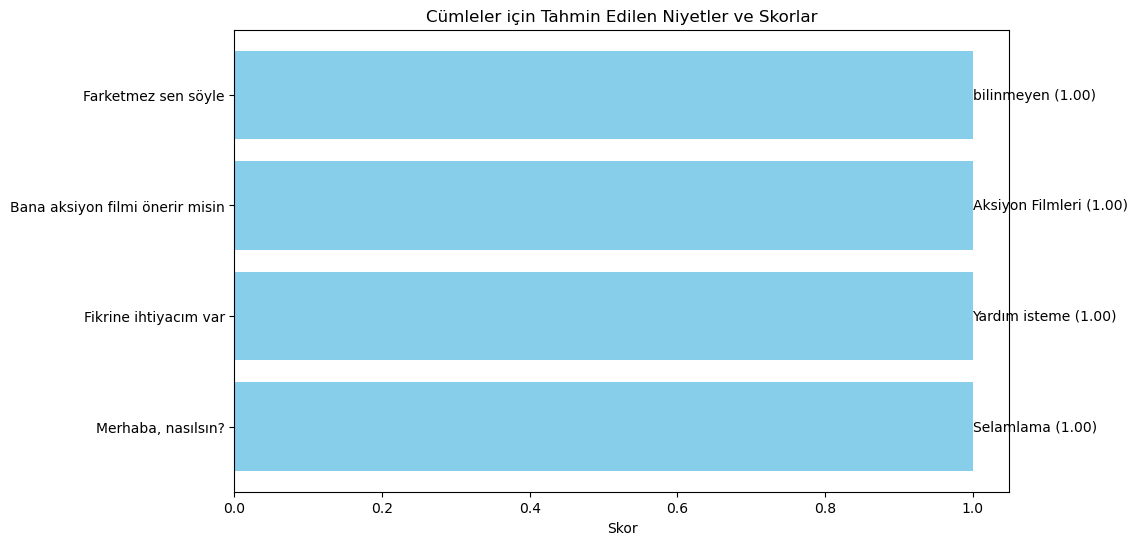

In [24]:
import matplotlib.pyplot as plt
examples = [
    "Merhaba, nasılsın?",
    "Fikrine ihtiyacım var",
    "Bana aksiyon filmi önerir misin",
    "Farketmez sen söyle"
]

predicted_labels = []
scores = []

for example in examples:
    inputs = tokenizer(example, return_tensors="pt", truncation=True, padding=True, max_length=256)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_id = logits.argmax().item()
    predicted_label = model.config.id2label[predicted_class_id]
    score = torch.nn.functional.softmax(logits, dim=-1).max().item()
    
    predicted_labels.append(predicted_label)
    scores.append(score)
    print(f"Cümle: '{example}' - Tahmin Edilen Niyet: '{predicted_label}', Skor: {score}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.barh(examples, scores, color='skyblue')
for i, (example, score) in enumerate(zip(examples, scores)):
    plt.text(score, i, f'{predicted_labels[i]} ({score:.2f})', va='center')
plt.xlabel('Skor')
plt.title('Cümleler için Tahmin Edilen Niyetler ve Skorlar')
plt.show()

In [25]:
def save_new_example(text, label):
    with open('C:/Users/Public/projectcode/database/intents.json', 'r+', encoding='utf-8') as f:
        data = json.load(f)
        
        for intent in data['intents']:
            if intent['tag'].lower() == label:
                intent['patterns'].append(text)
                break
        else:
            new_intent = {
                'tag': label,
                'patterns': [text],
                'responses': ["Geri bildiriminiz için teşekkür ederiz."]  # Uygun yanıtları buraya ekleyin
            }
            data['intents'].append(new_intent)
    
    with open('C:/Users/Public/projectcode/database/intents.json', 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)


In [26]:
def retrain_model():
    # Gerekli kütüphaneleri içe aktarın
    from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding
    from datasets import Dataset
    import pandas as pd
    
    # Tokenizer ve model yükleme
    tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-uncased")
    model = AutoModelForSequenceClassification.from_pretrained("dbmdz/bert-base-turkish-uncased", num_labels=num_labels)

    # Verileri işleme fonksiyonu
    def preprocess_function(examples):
        return tokenizer(examples['text'], padding="max_length", truncation=True)

    def tokenize_data(data):
        tokenized_data = Dataset.from_pandas(data)
        tokenized_data = tokenized_data.map(preprocess_function, batched=True)
        return tokenized_data

    # intents.json dosyasını yükle ve verileri işleyin
    with open('C:/Users/Public/projectcode/database/intents.json', 'r', encoding='utf-8') as f:
        intents = json.load(f)
    
    # Verileri pandas DataFrame'e çevir
    data = []
    for intent in intents['intents']:
        tag = intent['tag']
        for pattern in intent['patterns']:
            data.append((pattern, tag))
    
    df = pd.DataFrame(data, columns=['Pattern', 'Tag'])
    
    labels = df['Tag'].unique()
    labels = [s.strip() for s in labels]
    if 'bilinmeyen' not in labels:
        labels.append('bilinmeyen')

    num_labels = len(labels)
    id2label = {id: label for id, label in enumerate(labels)}
    label2id = {label: id for id, label in id2label.items()}

    df['labels'] = df['Tag'].map(lambda x: label2id[x.strip()])

    X = list(df['Pattern'])
    y = list(df['labels'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

    train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=128)
    test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=128)

    class CustomDataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item

        def __len__(self):
            return len(self.labels)

    train_dataset = CustomDataset(train_encodings, y_train)
    test_dataset = CustomDataset(test_encodings, y_test)

    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer
    )

    trainer.train()

    model.save_pretrained('C:/Users/Public/projectcode/models')
    tokenizer.save_pretrained('C:/Users/Public/projectcode/models')

    print("Model yeniden eğitildi ve kaydedildi.")


In [27]:
# API için inference fonksiyonu
def get_response(message):
    from transformers import pipeline
    
    model_path = 'C:/Users/Public/projectcode/chatbot'
    classifier = pipeline('text-classification', model=model_path, tokenizer=model_path)
    predictions = classifier(message)
    predicted_label = id2label[int(predictions[0]['label'].split('_')[-1])]
    return predicted_label